In [209]:
import numpy as np
import pandas as pd
import os
from scipy import stats
import sklearn 
import matplotlib.pyplot as plt
import matplotlib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.decomposition import PCA




from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve,f1_score

### Première observation et statistiques descriptique des bases

Nous avons scrappé 15399 morceaux, dont les features ont été séparés en 3 bases distinctes. La première df_track regroupe l'id, le titre et genre du morceaux ainsi que des caractéristiques comme son "énergie" (sorte de note entre 0 et 1), son tempo, sa durée etc. Nous avons notamment scrappé 1711 morceaux pour chacun des 9 genres différents. (nous avons réalisé un autre notebook pour le scrapping des données, que nous fusionneront plus tard).
Le seconde, df_pitches regroupe l'id et les 125 premiers chromagrammes de ces morceaux : un chromagramme est un vecteur de 12 coefficients (correspondant aux 12 classes de notes) contenant des valeurs allant de 0 à 1 qui décrivent la dominance relative de chaque "hauteur" dans l'échelle chromatique.
La dernière, df_timbres regroupe l'id et les 125 premières fonction de timbres : vecteur de 12 coefficients centrés autour de 0,nous informant sur la surface spectrale du son, classées par degré d'importance (le premier représente le volume sonore moyen du segment, le seconde la luminosité etc.)

In [53]:
df_track = pd.read_csv(os.path.join('Database','tracksMeta_new.csv'), index_col = 0)
df_pitches = pd.read_csv(os.path.join('Database','tracksPitches.csv'), index_col = 0)
df_timbres = pd.read_csv(os.path.join('Database','tracksTimbres.csv'), index_col = 0)

In [54]:
df_track

,track_name,track_artists,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,,,,
2wiA6eP7rBktnxmjgX8g7U,Penetration in the Centrefold - 2010 Remaster,DEVO,rock,0.579,0.713,1.0,-10.438,1.0,0.0361,0.16400,0.001260,0.2330,0.831,115.665,149427.0,4.0
48xD8fTt37etYF52AJBiXF,Fever,Judas Priest,rock,0.486,0.696,9.0,-7.557,1.0,0.0406,0.00671,0.000141,0.1140,0.325,111.370,320253.0,4.0
74wIEdRJGZR5aaKu2XnREO,Don't Wanna Let You Go,Quiet Riot,rock,0.638,0.806,2.0,-6.989,1.0,0.0529,0.10500,0.000247,0.0803,0.830,108.257,281133.0,4.0
25YlltWXRb9k7KbrEBRuhJ,Lo/Hi,The Black Keys,rock,0.606,0.679,2.0,-7.445,1.0,0.0321,0.01510,0.000433,0.0962,0.707,122.016,177768.0,4.0
2CczZm7lbN6DEeOvct2K6s,New Minglewood Blues - Live at Nassau Coliseum...,Grateful Dead,rock,0.612,0.802,9.0,-9.715,1.0,0.0438,0.61700,0.101000,0.7190,0.673,104.453,454573.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CMGAu0krhuwn7BKpjwLz0,The Judge,Buddy Brown,country,0.518,0.754,1.0,-6.366,1.0,0.0444,0.00701,0.000012,0.1010,0.560,175.999,211547.0,4.0
5SzBQvpCZGuWP3FcLlUtVd,Jingle Bell Rock,Blake Shelton,country,0.650,0.736,0.0,-5.222,1.0,0.0378,0.12200,0.000000,0.0998,0.595,129.941,123400.0,4.0
5d0O0zKttFsO60cXzdQYjX,Flyin' Saucers Rock 'n' Roll,Billy Lee Riley,country,0.430,0.653,2.0,-8.957,1.0,0.0732,0.68400,0.000029,0.2200,0.679,165.018,122108.0,4.0


#### Description par genre

Ce qui nous intéresse ici, c'est d'évaluer le niveau de ces différentes caractéristiques en fonction du genre du morceau, afin d'essayer de déterminer ce qui les distingue. En effet, il sera plus facile de prédire l'appartenance d'un morceau à un genre si chaque genre a des caractéristiques très différentes des autres.

In [55]:
#On calcule la moyenne de chaque caractéristique en fonction du genre du morceau
df_genres = df_track.groupby(['genre']).mean()
df_genres

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
genre,,,,,,,,,,,,,
blues,0.585086,0.554949,5.294565,-10.034371,0.685564,0.069123,0.363364,0.084557,0.237955,0.621897,120.044381,241316.461718,3.852718
classical,0.367434,0.142377,5.218586,-21.609019,0.728229,0.047269,0.923316,0.661553,0.157827,0.399849,109.586611,193143.167738,3.639392
country,0.576761,0.572595,5.284044,-9.119131,0.900058,0.050758,0.387786,0.036688,0.232559,0.583805,120.913948,210194.998247,3.908241
disco,0.657542,0.710581,5.429573,-7.430791,0.582700,0.090320,0.164143,0.126473,0.201733,0.596846,119.500873,260291.415546,3.966686
hip hop,0.703216,0.685032,5.458796,-7.280680,0.549971,0.227830,0.161215,0.065860,0.216463,0.563614,115.014078,227406.452367,3.977791
house,0.670320,0.733630,5.525424,-7.487143,0.521333,0.083277,0.130165,0.371764,0.195663,0.437819,124.022825,279204.056692,3.971362
jazz,0.625441,0.313417,4.923437,-16.282840,0.577440,0.061530,0.661095,0.562049,0.168764,0.529027,110.510886,219001.766219,3.845704
metal,0.418486,0.882296,5.203390,-5.710610,0.620105,0.091481,0.031595,0.164800,0.266478,0.366665,128.652985,257114.170660,3.911748
rock,0.499080,0.663306,5.222092,-9.038712,0.710111,0.067603,0.260850,0.109036,0.308368,0.534979,123.324715,270387.388662,3.934541


In [56]:
#Au-delà de la simple moyenne on peut calculer d'autres statistiques descriptives en fonction du genre 
df_genres_describe = df_track.groupby(['genre']).describe()
df_genres_describe

danceability                                                     \
                 count      mean       std     min     25%    50%     75%   
genre                                                                       
blues           1711.0  0.585086  0.160914  0.1490  0.4680  0.587  0.7095   
classical       1711.0  0.367434  0.140182  0.0000  0.2650  0.374  0.4625   
country         1711.0  0.576761  0.121644  0.0000  0.5000  0.583  0.6590   
disco           1711.0  0.657542  0.150282  0.0844  0.5710  0.677  0.7650   
hip hop         1711.0  0.703216  0.143000  0.0941  0.6140  0.725  0.8115   
house           1711.0  0.670320  0.144667  0.1040  0.5865  0.689  0.7790   
jazz            1711.0  0.625441  0.147382  0.1200  0.5280  0.641  0.7325   
metal           1711.0  0.418486  0.145766  0.0607  0.3045  0.425  0.5280   
rock            1711.0  0.499080  0.160413  0.0875  0.3790  0.501  0.6110   

                  energy            ... duration_ms            time_signature  \
             max   count      mean  ...         75%        max          count   
genre                               ...                                         
blues      0.967  1711.0  0.554949  ...    276733.0  1024933.0         1711.0   
classical  0.802  1711.0  0.142377  ...    218553.0  1443787.0         1711.0   
country    0.942  1711.0  0.572595  ...    238189.0   598627.0         1711.0   
disco      0.973  1711.0  0.710581  ...    294553.0   922120.0         1711.0   
hip hop    0.961  1711.0  0.685032  ...    265720.0   962200.0         1711.0   
house      0.988  1711.0  0.733630  ...    331132.5  2669911.0         1711.0   
jazz       0.964  1711.0  0.313417  ...    263055.0  1589533.0         1711.0   
metal      0.852  1711.0  0.882296  ...    291341.0  1008000.0         1711.0   
rock       0.944  1711.0  0.663306  ...    303420.0  1827507.0         1711.0   

                                                        
               mean       std  min  25%  50%  75%  max  
genre                                                   
blues      3.852718  0.425011  1.0  4.0  4.0  4.0  5.0  
classical  3.639392  0.724066  0.0  3.0  4.0  4.0  5.0  
country    3.908241  0.379746  0.0  4.0  4.0  4.0  5.0  
disco      3.966686  0.254895  1.0  4.0  4.0  4.0  5.0  
hip hop    3.977791  0.308890  1.0  4.0  4.0  4.0  5.0  
house      3.971362  0.215749  1.0  4.0  4.0  4.0  5.0  
jazz       3.845704  0.467209  1.0  4.0  4.0  4.0  5.0  
metal      3.911748  0.366486  1.0  4.0  4.0  4.0  5.0  
rock       3.934541  0.317767  1.0  4.0  4.0  4.0  5.0  

[9 rows x 104 columns]

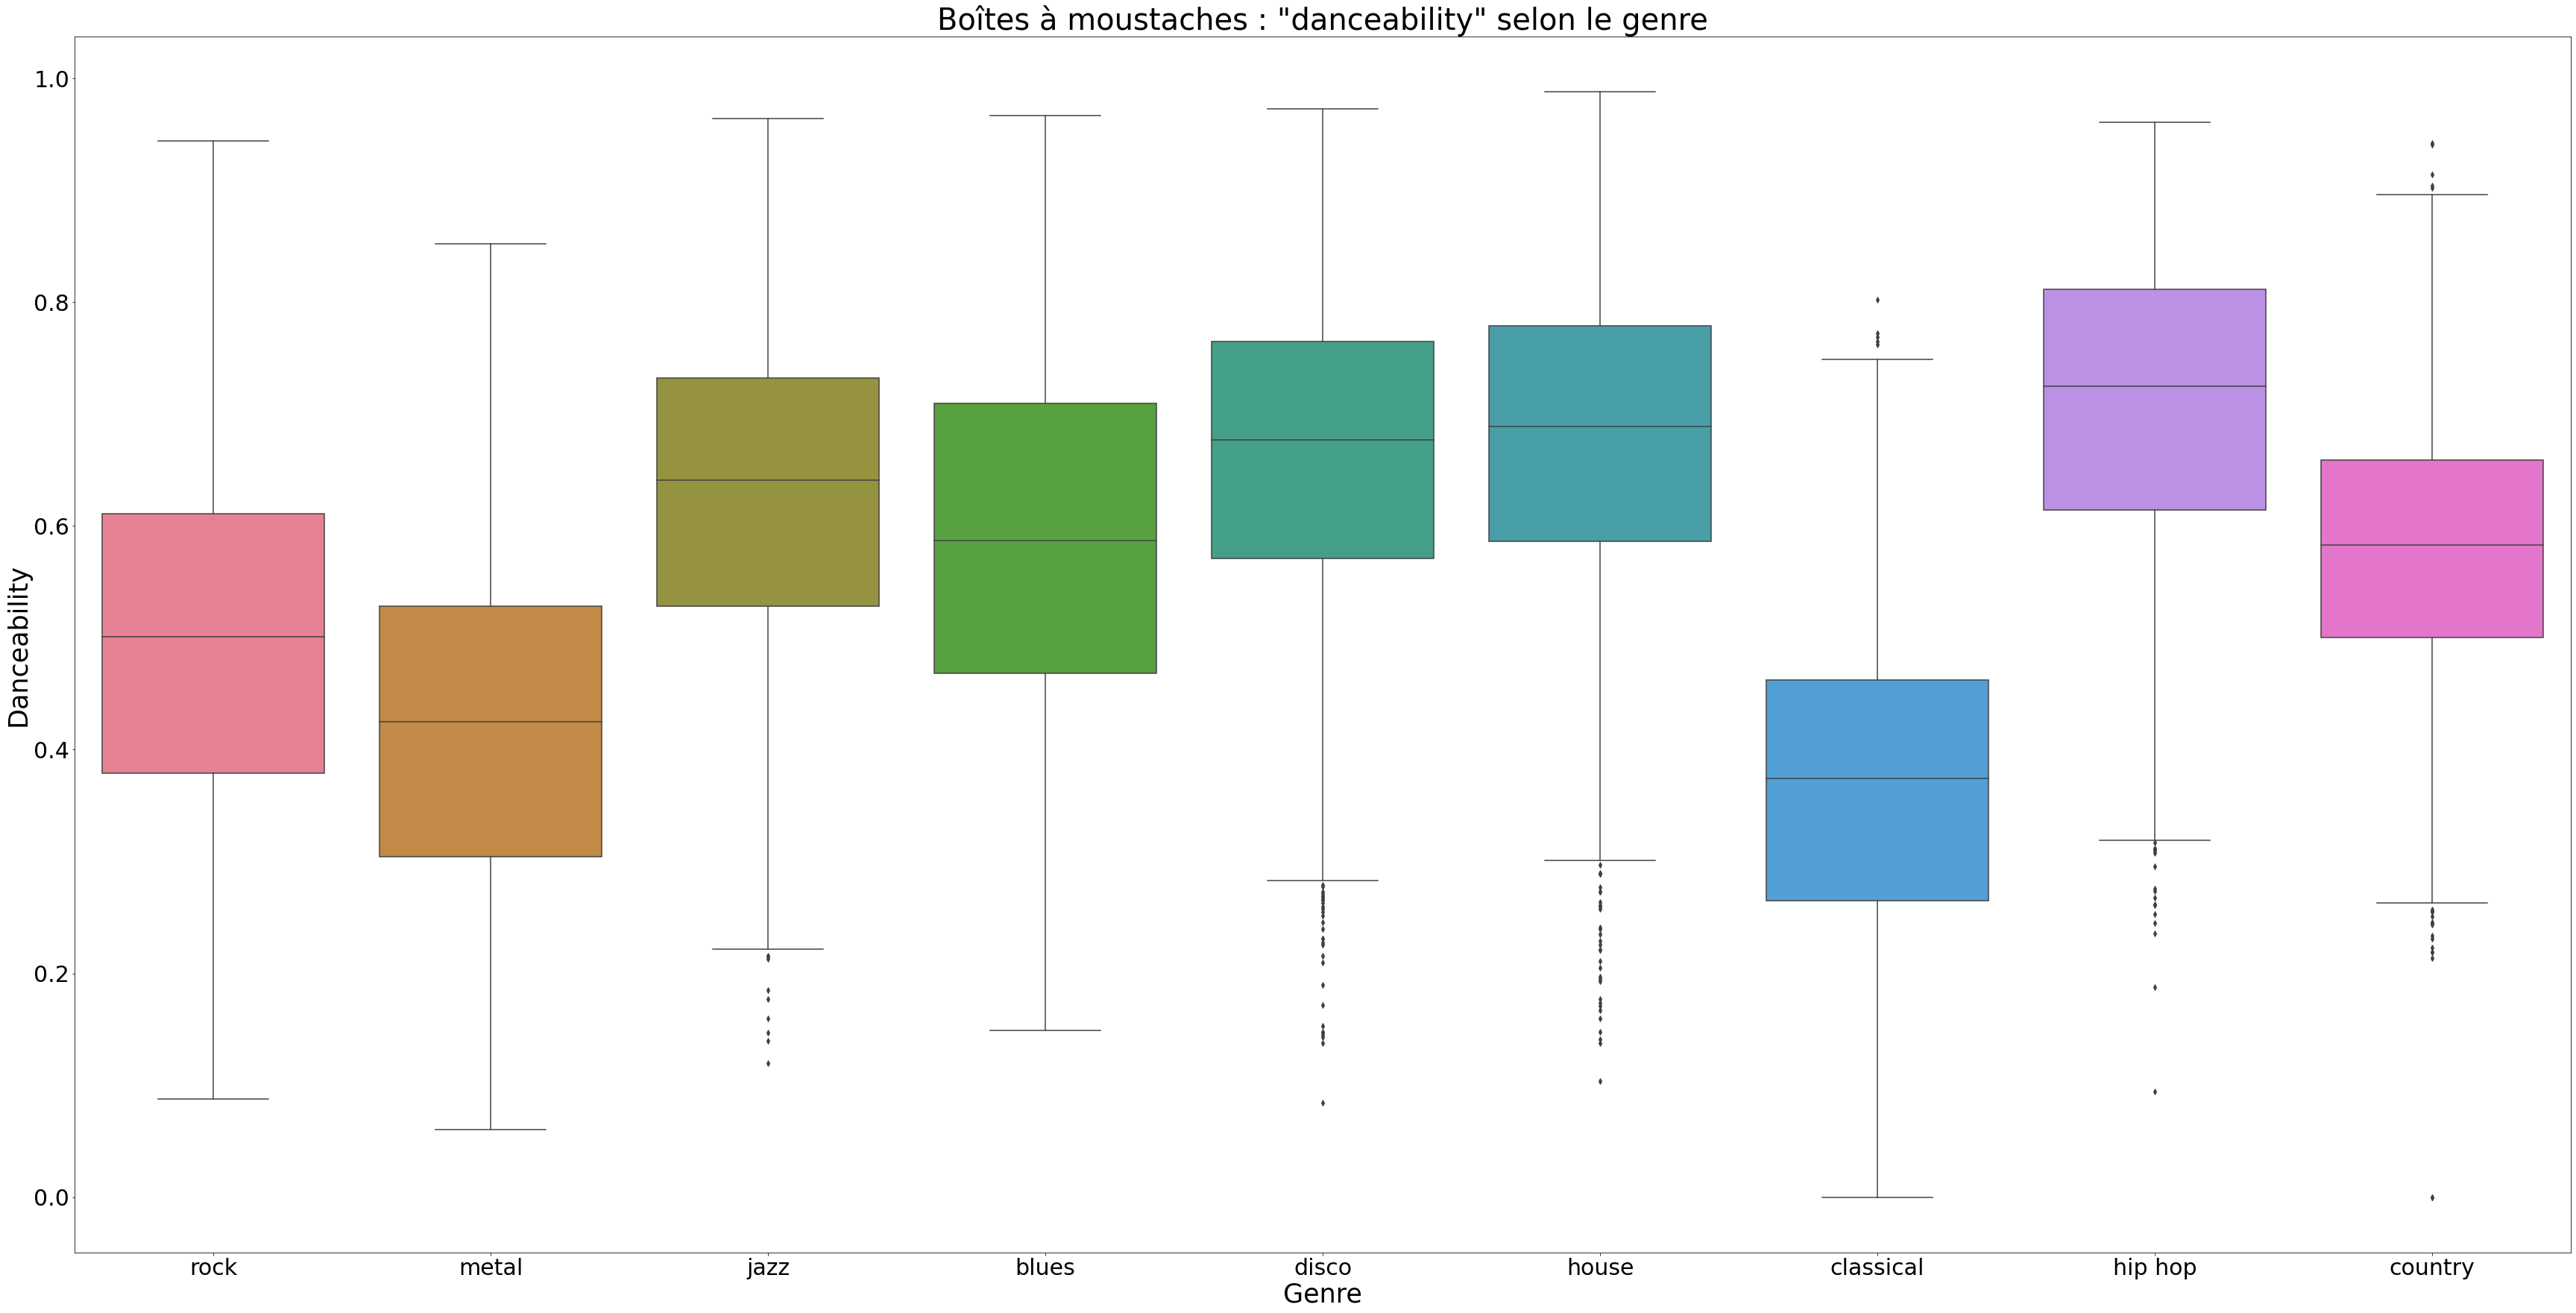

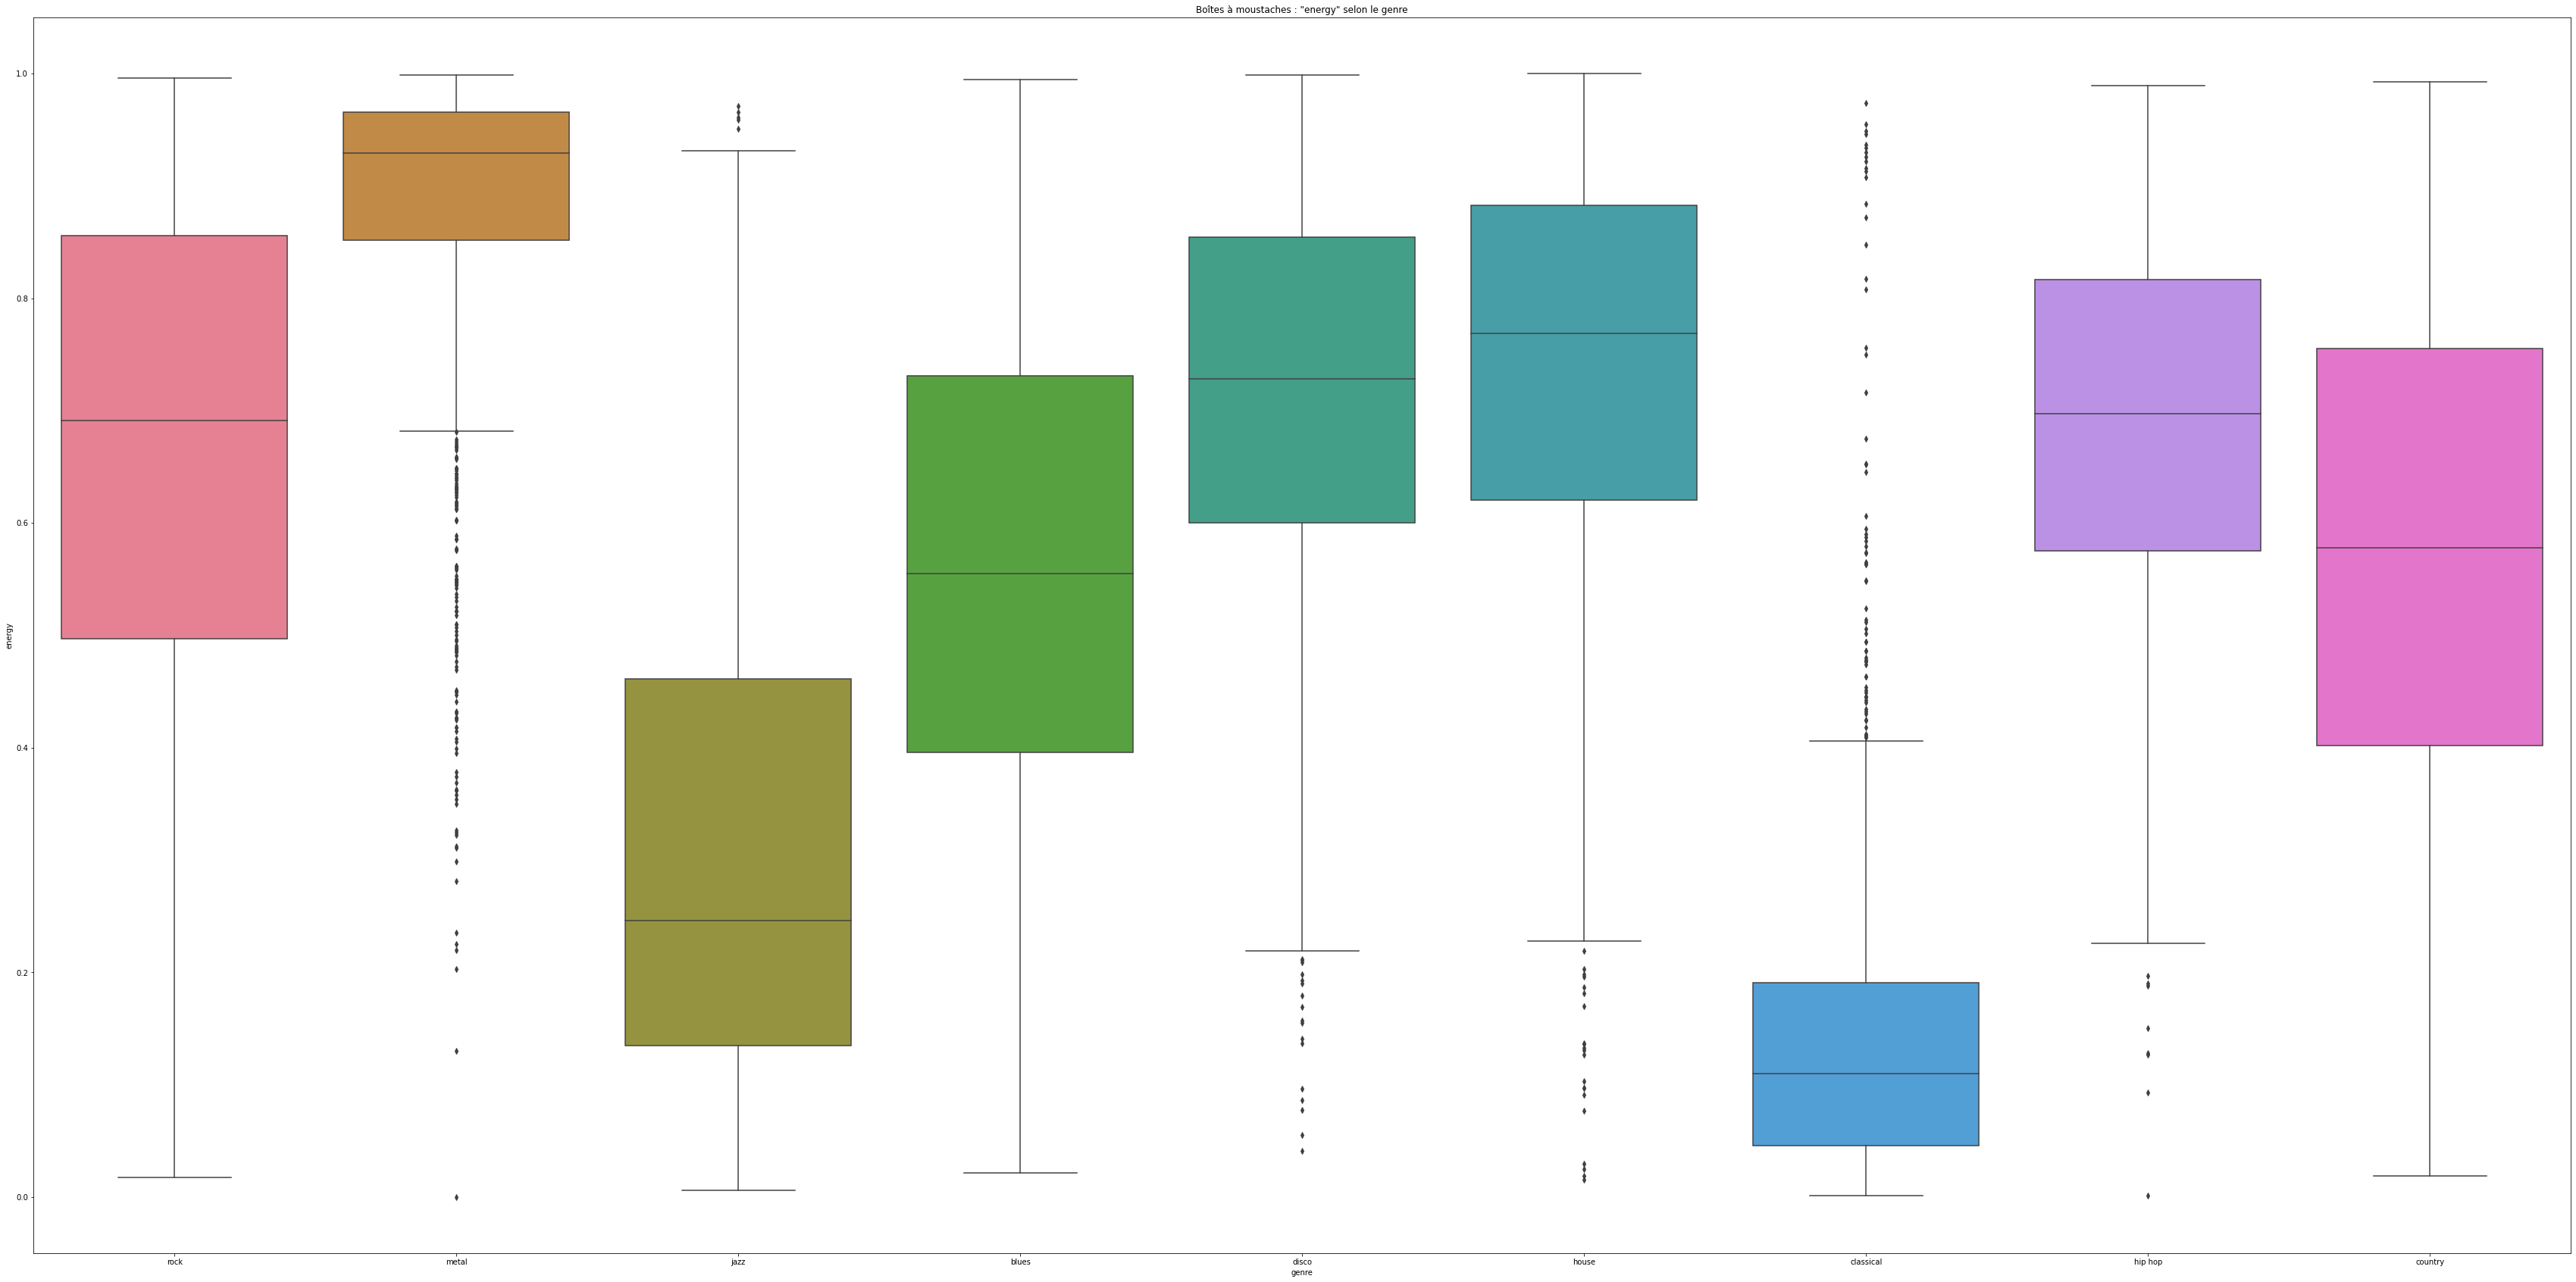

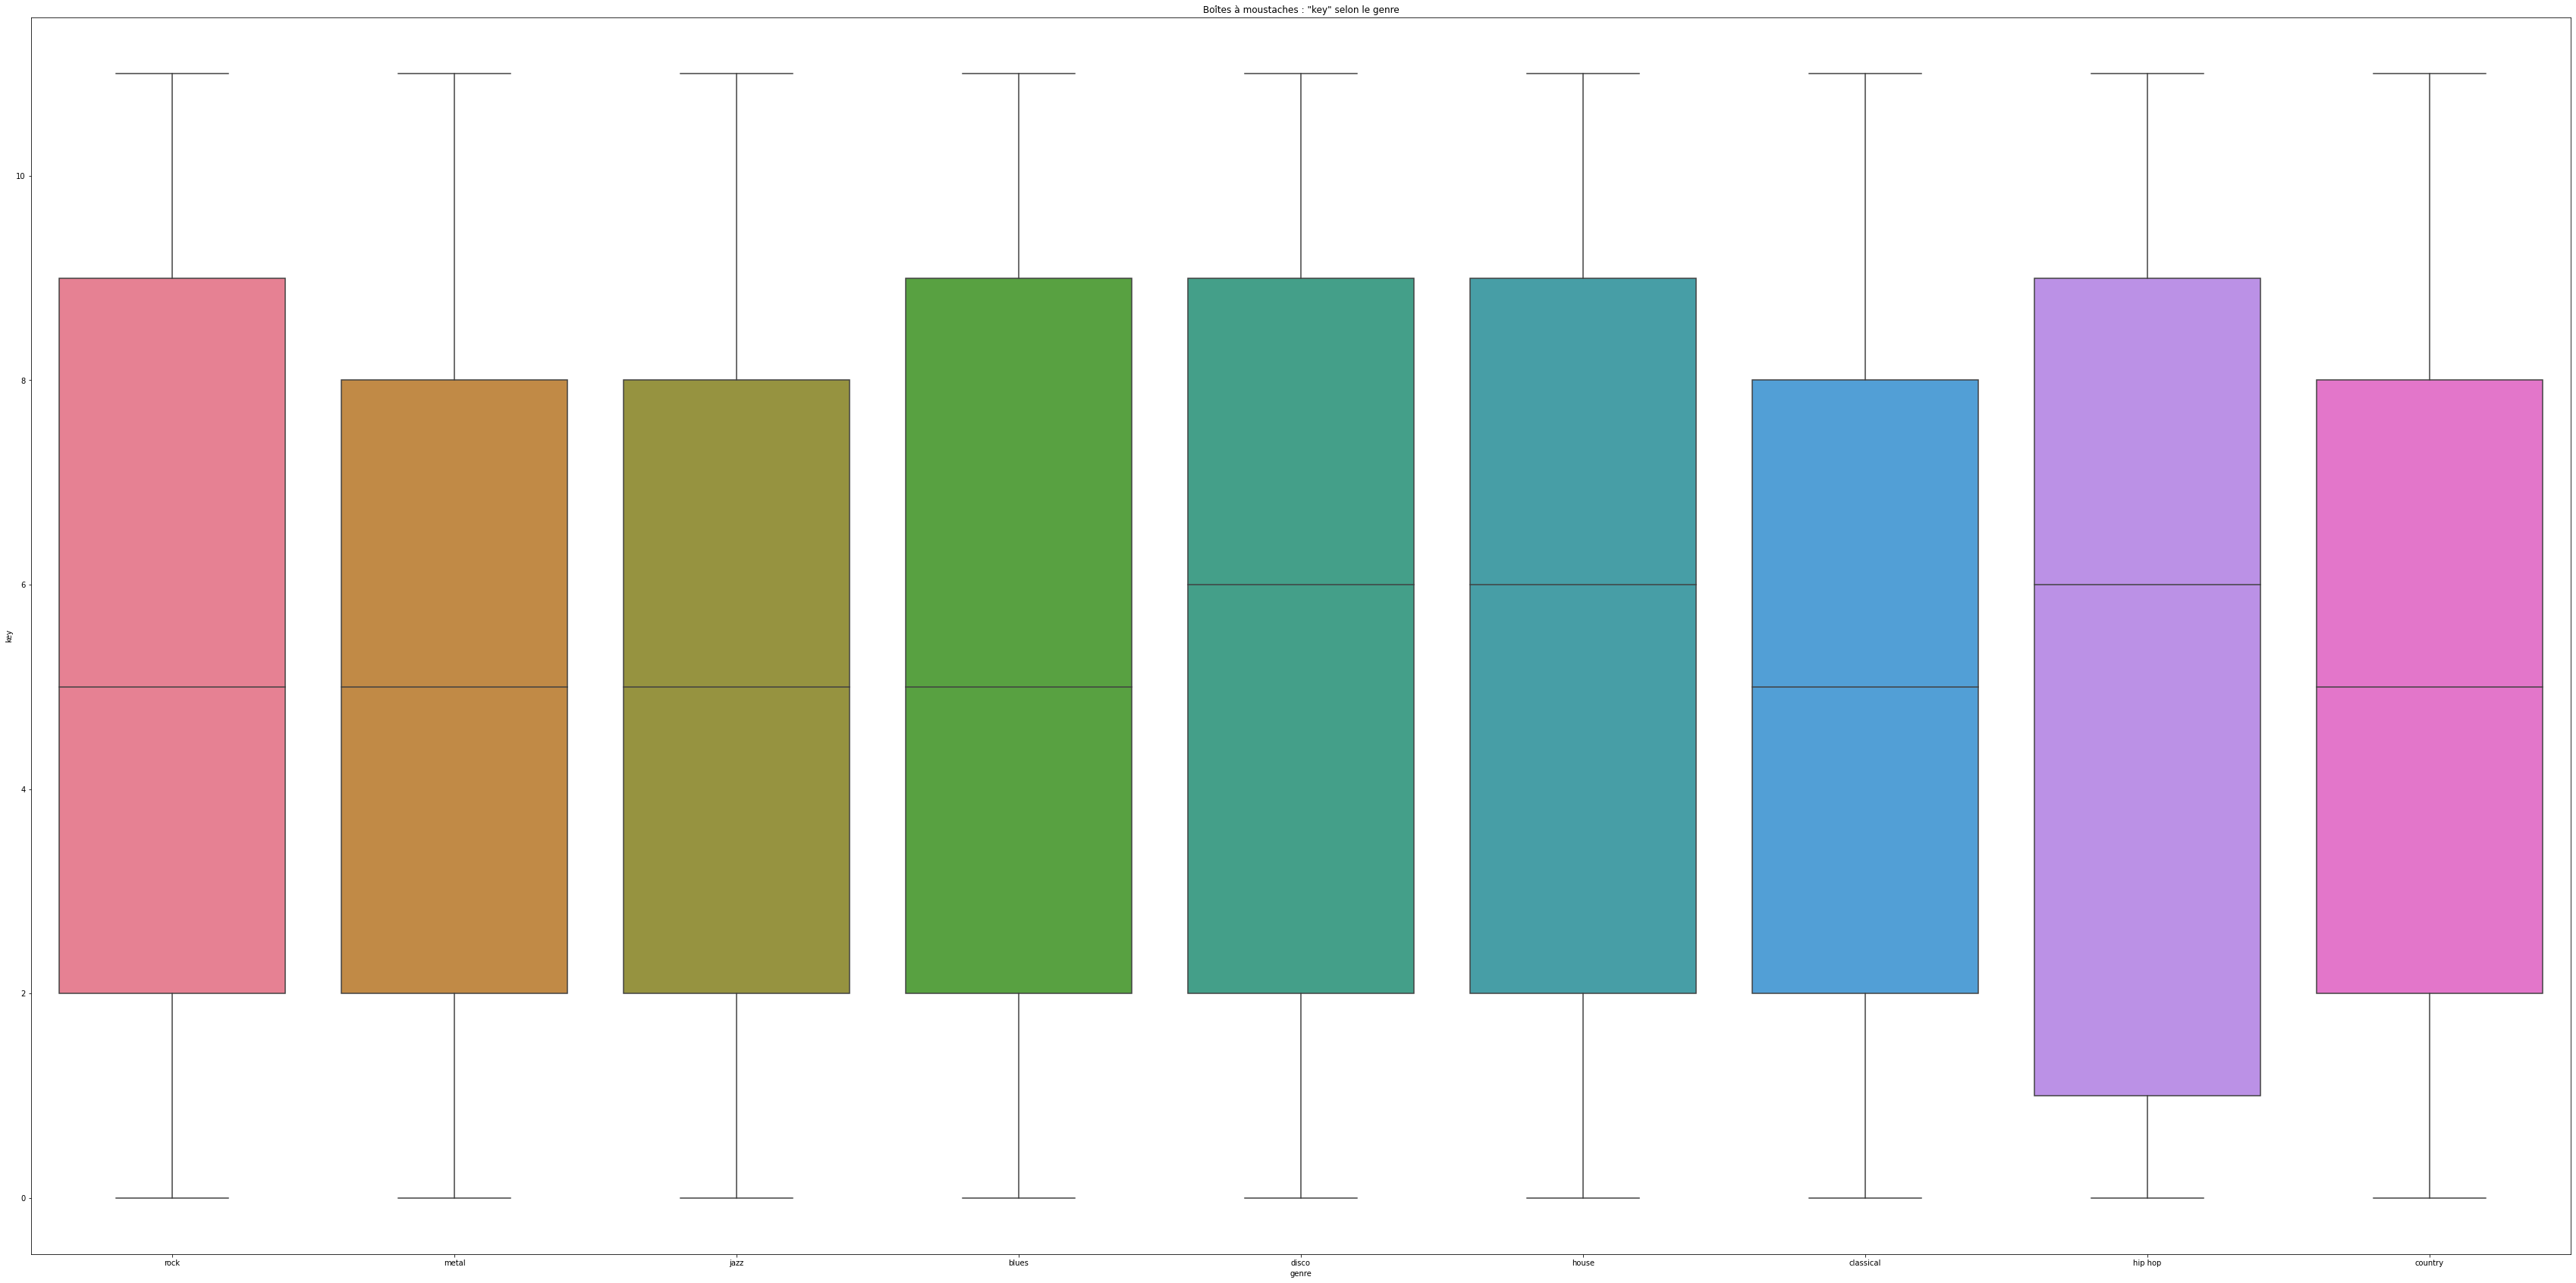

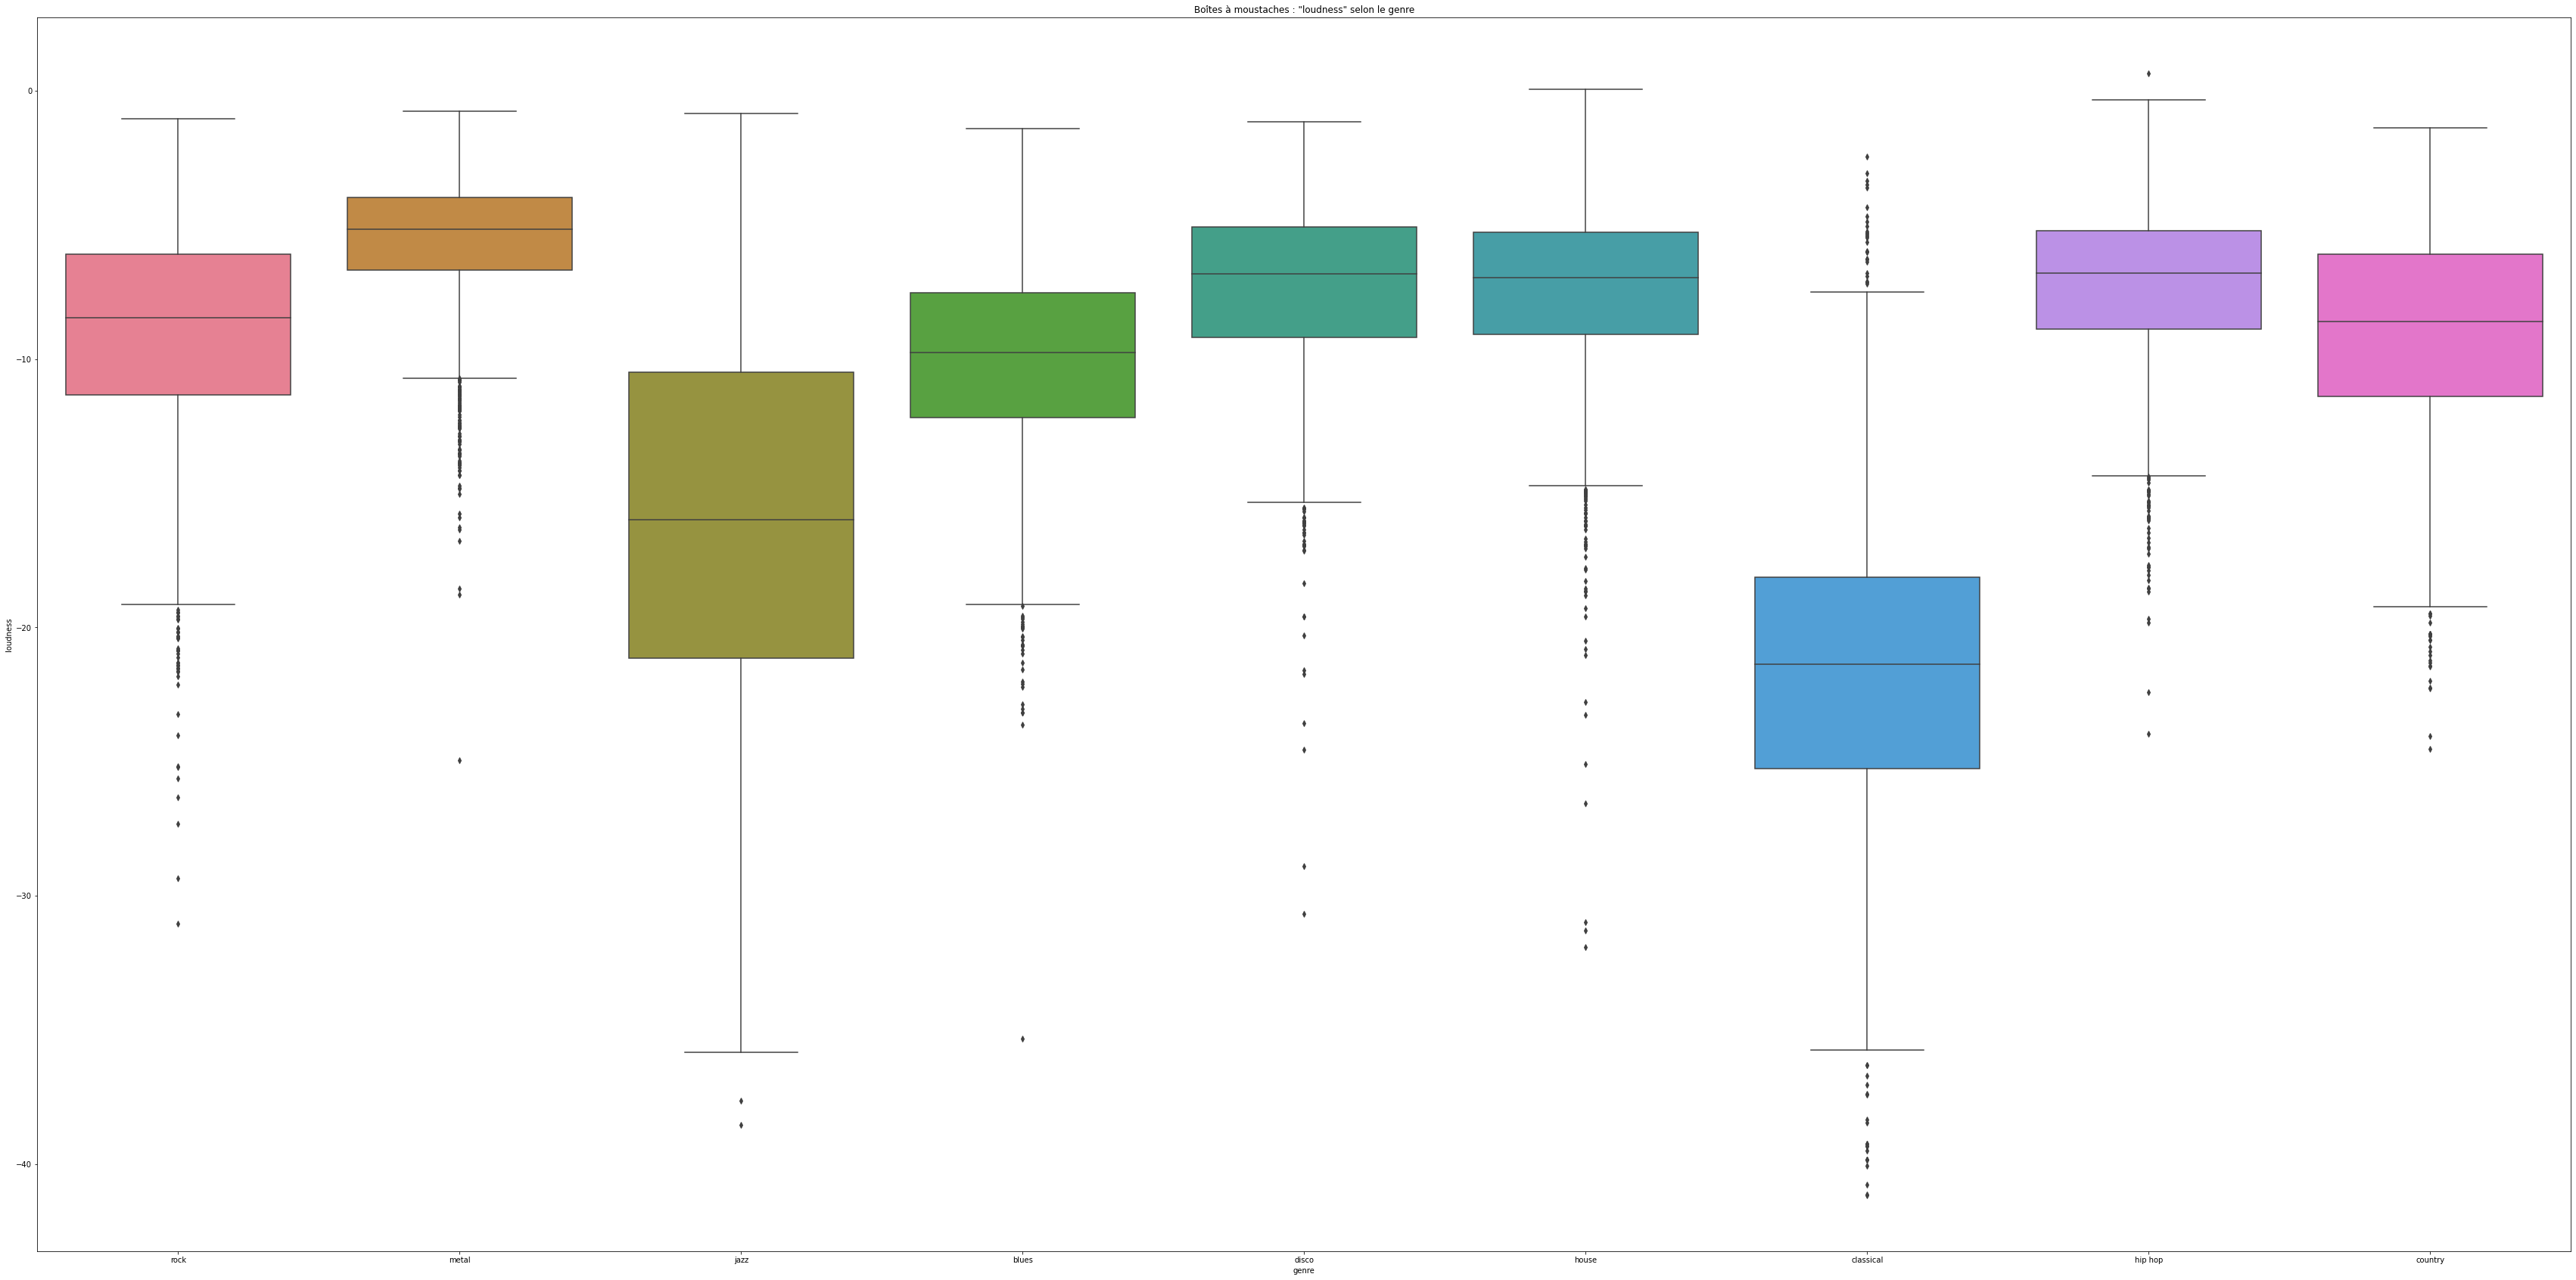

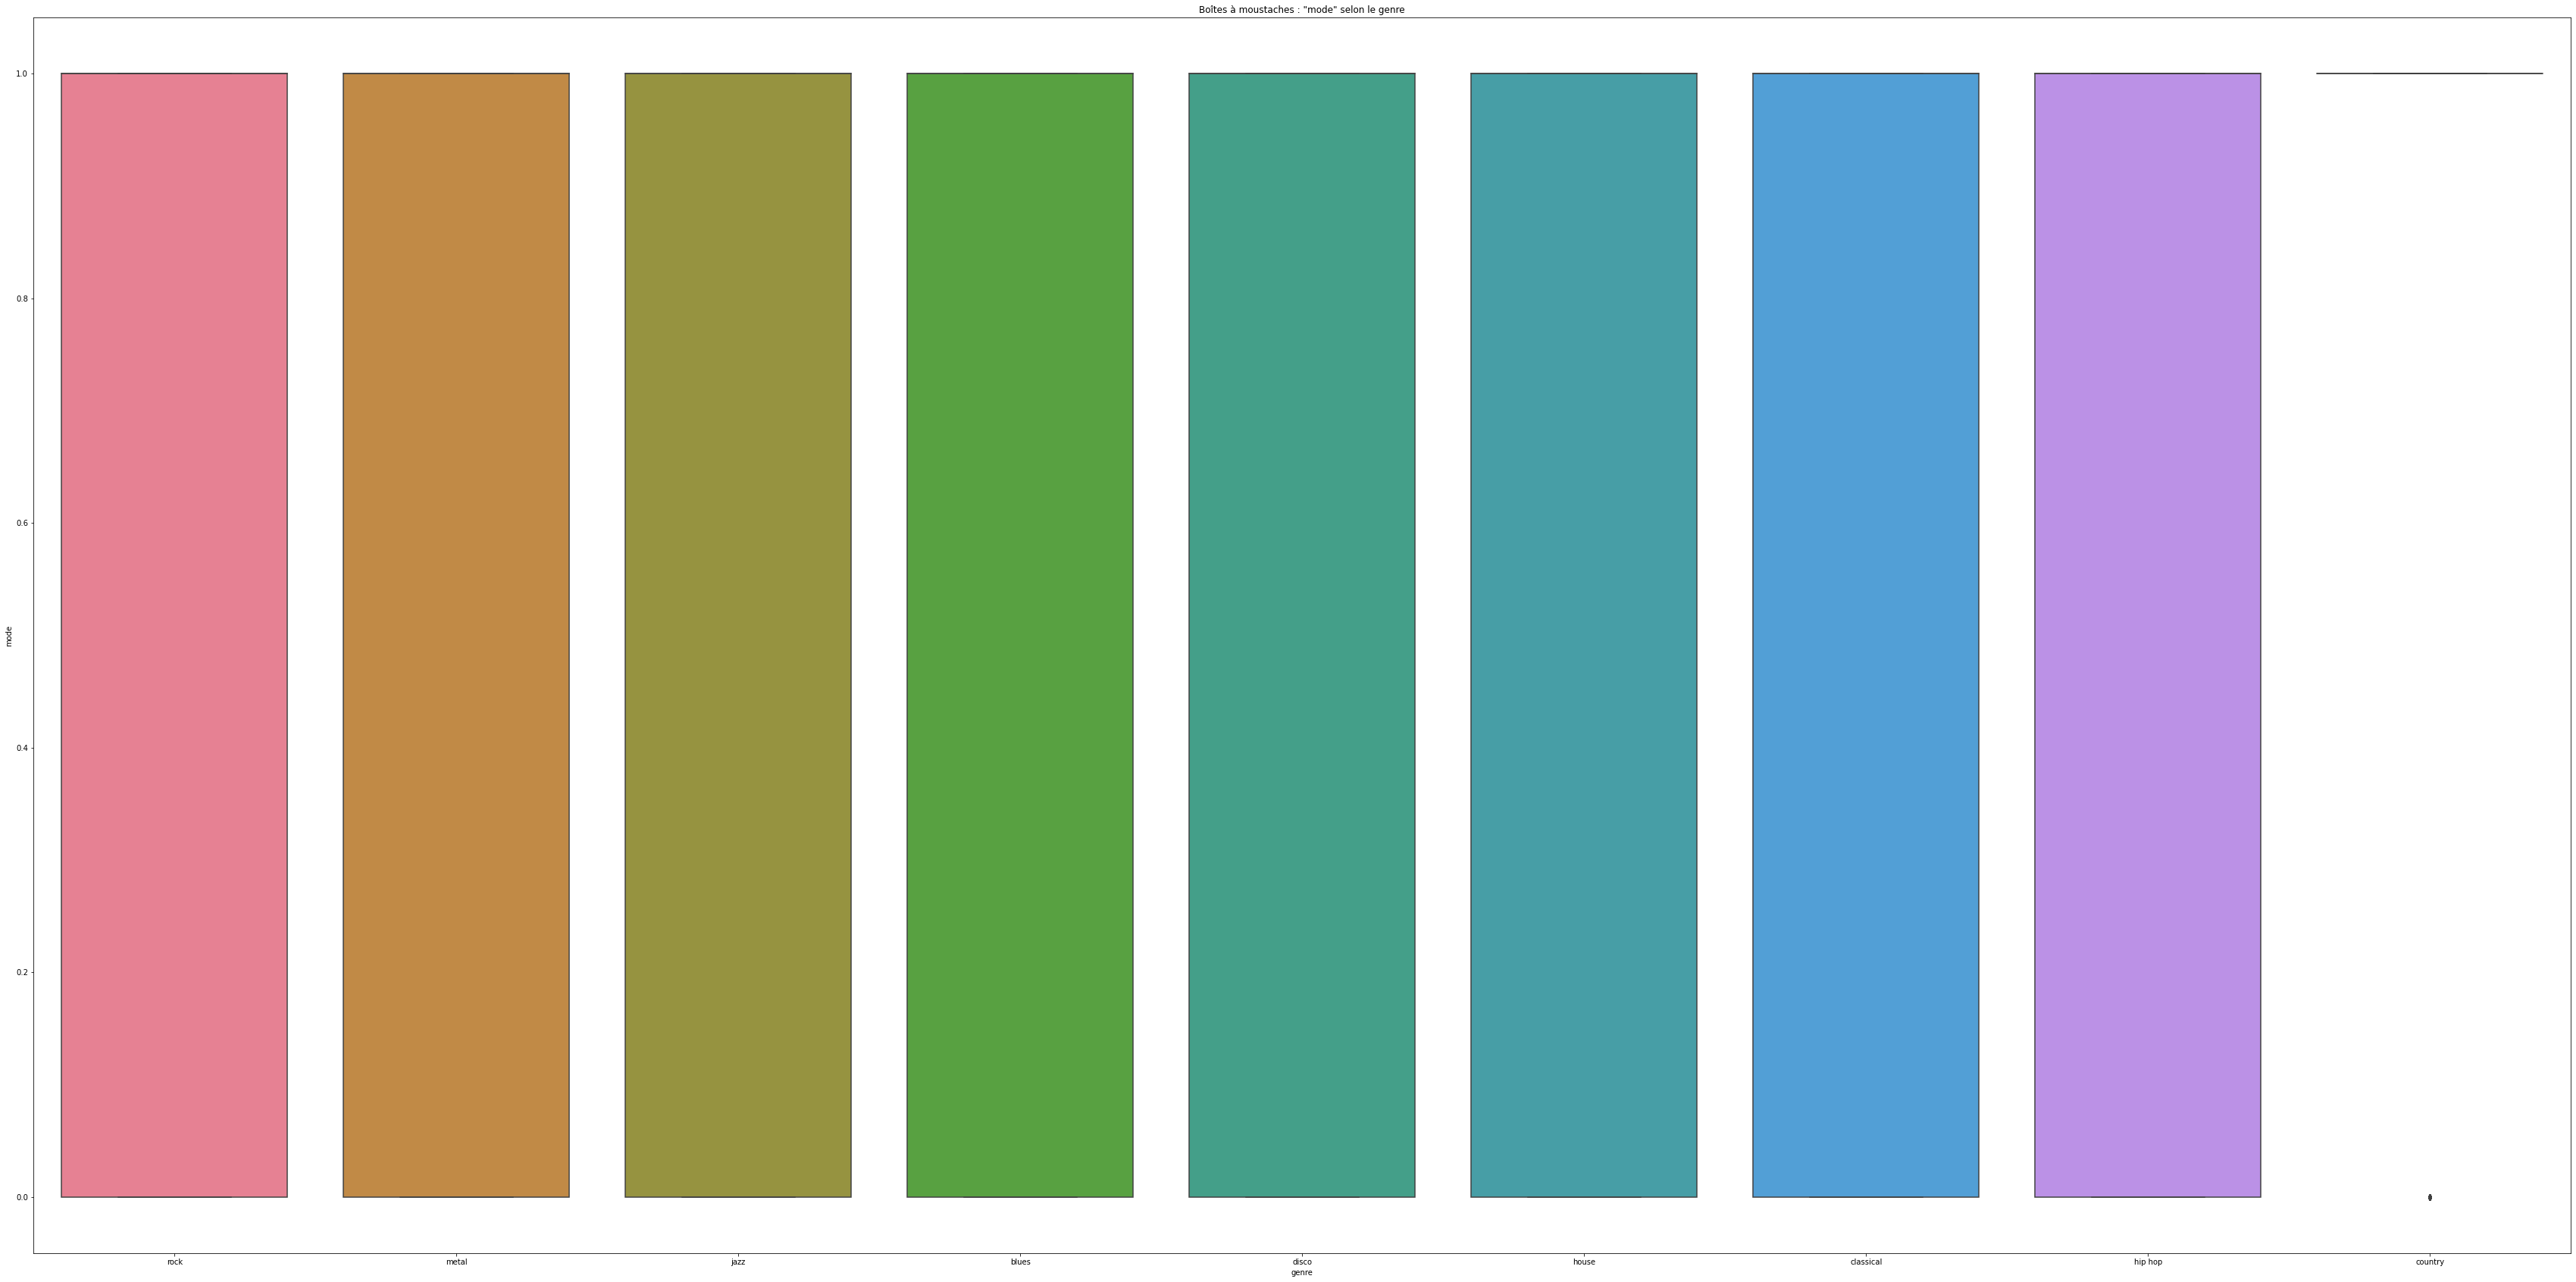

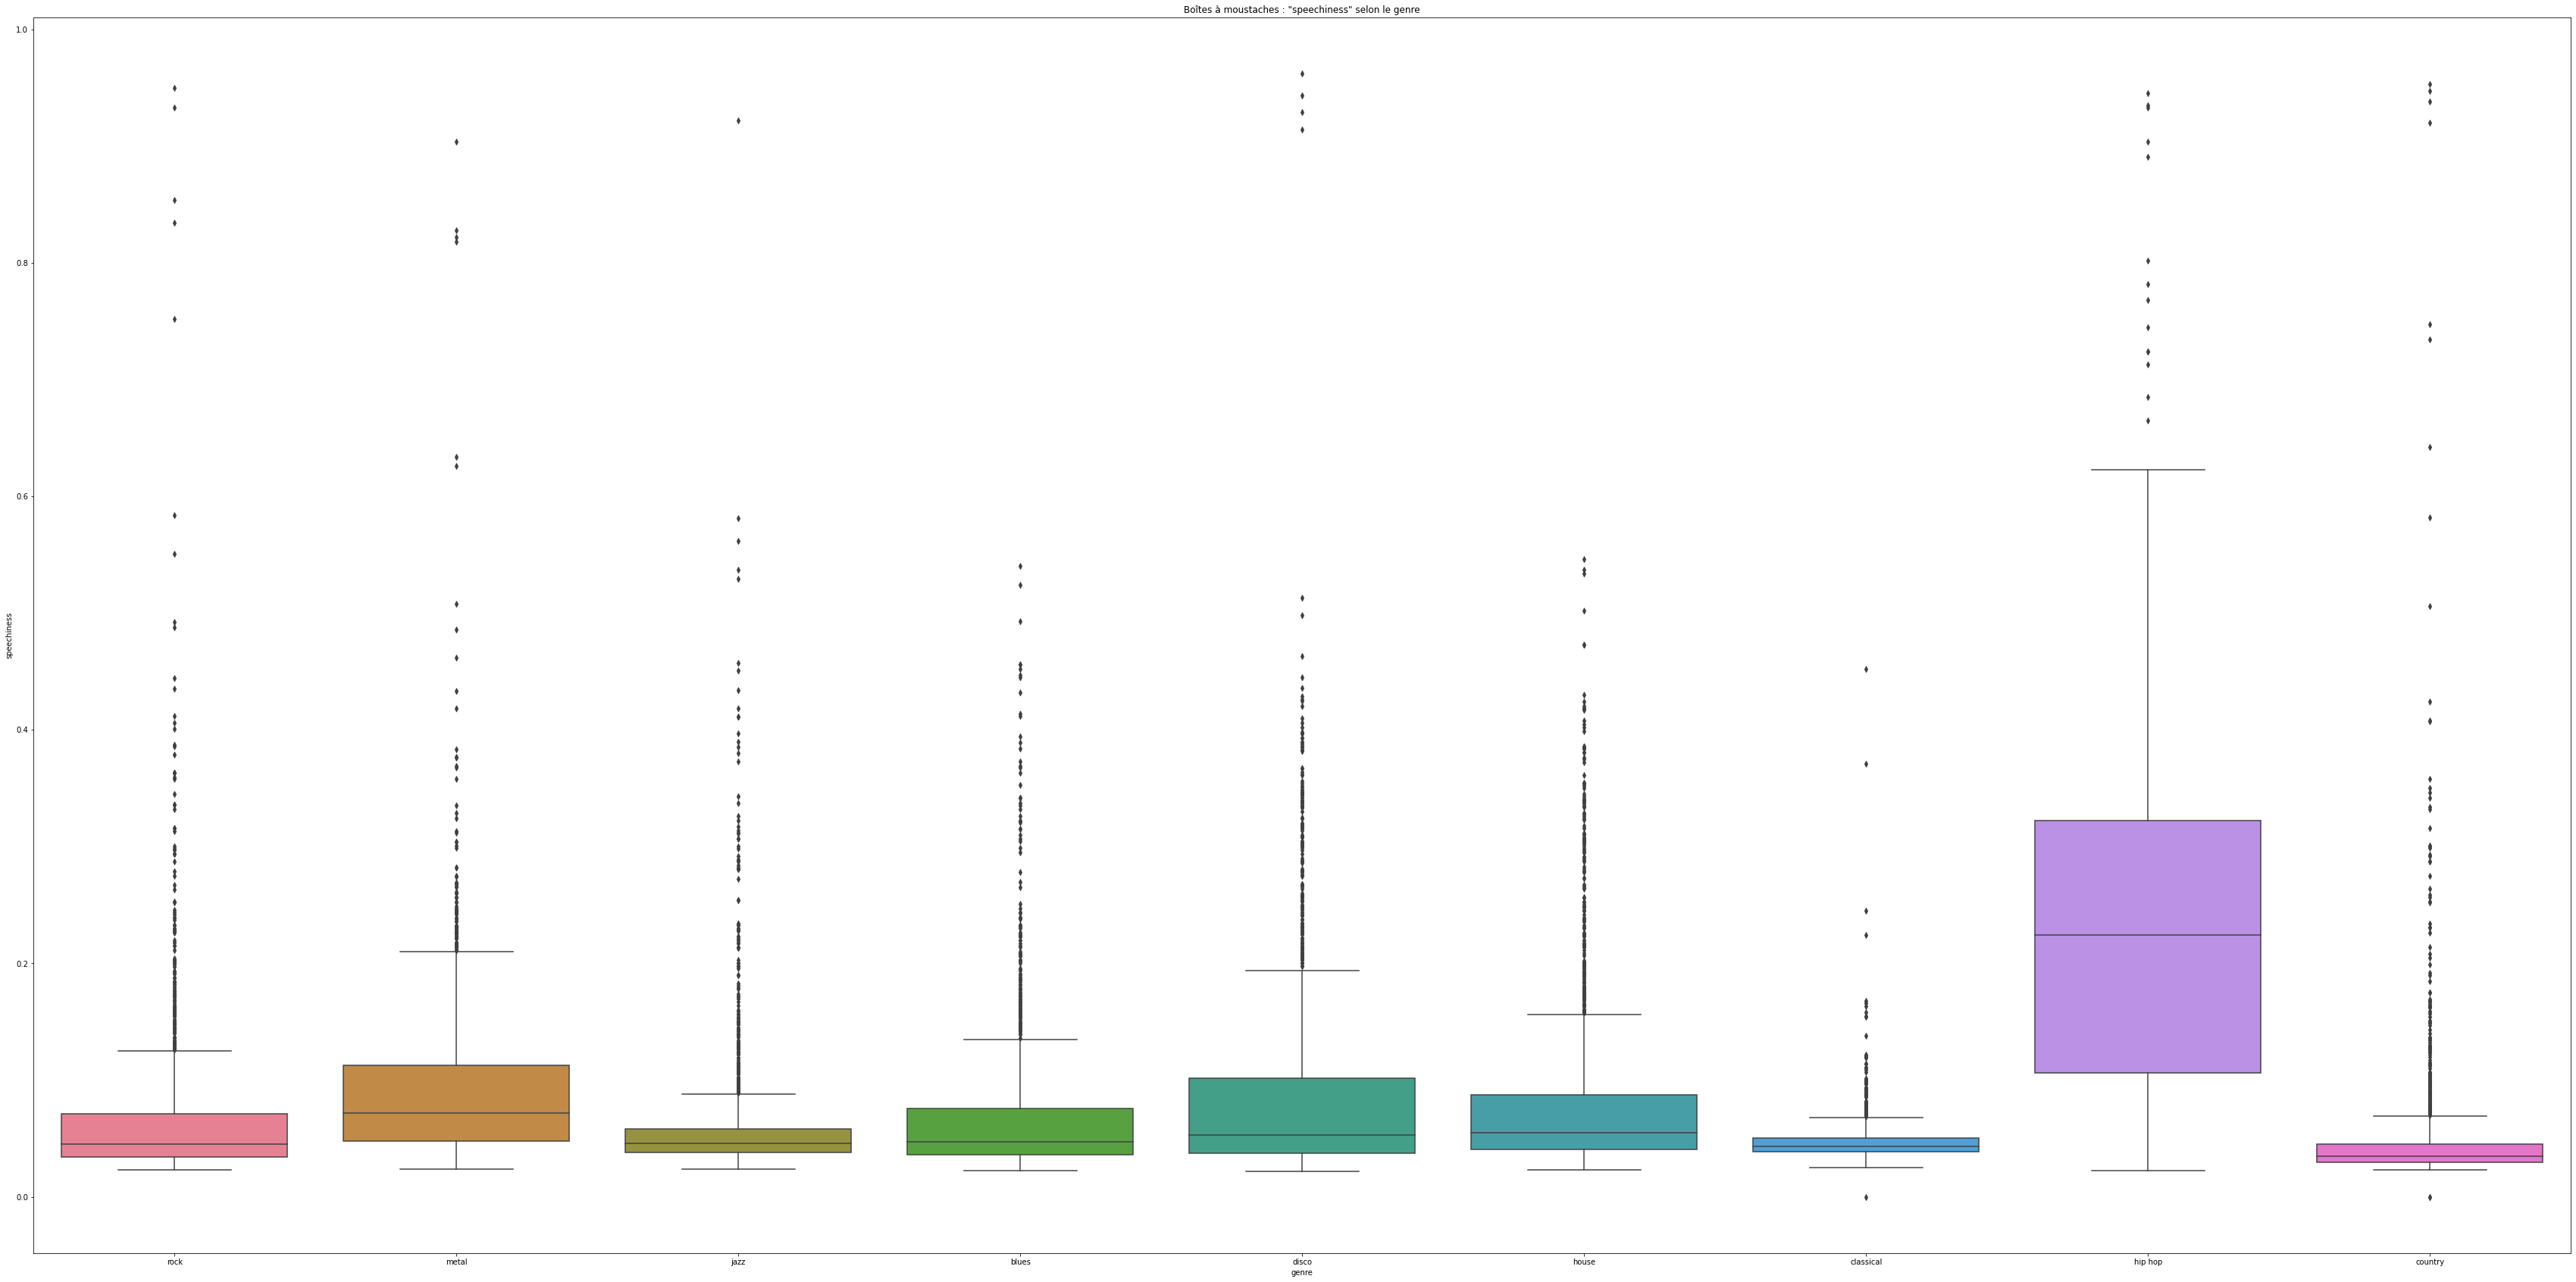

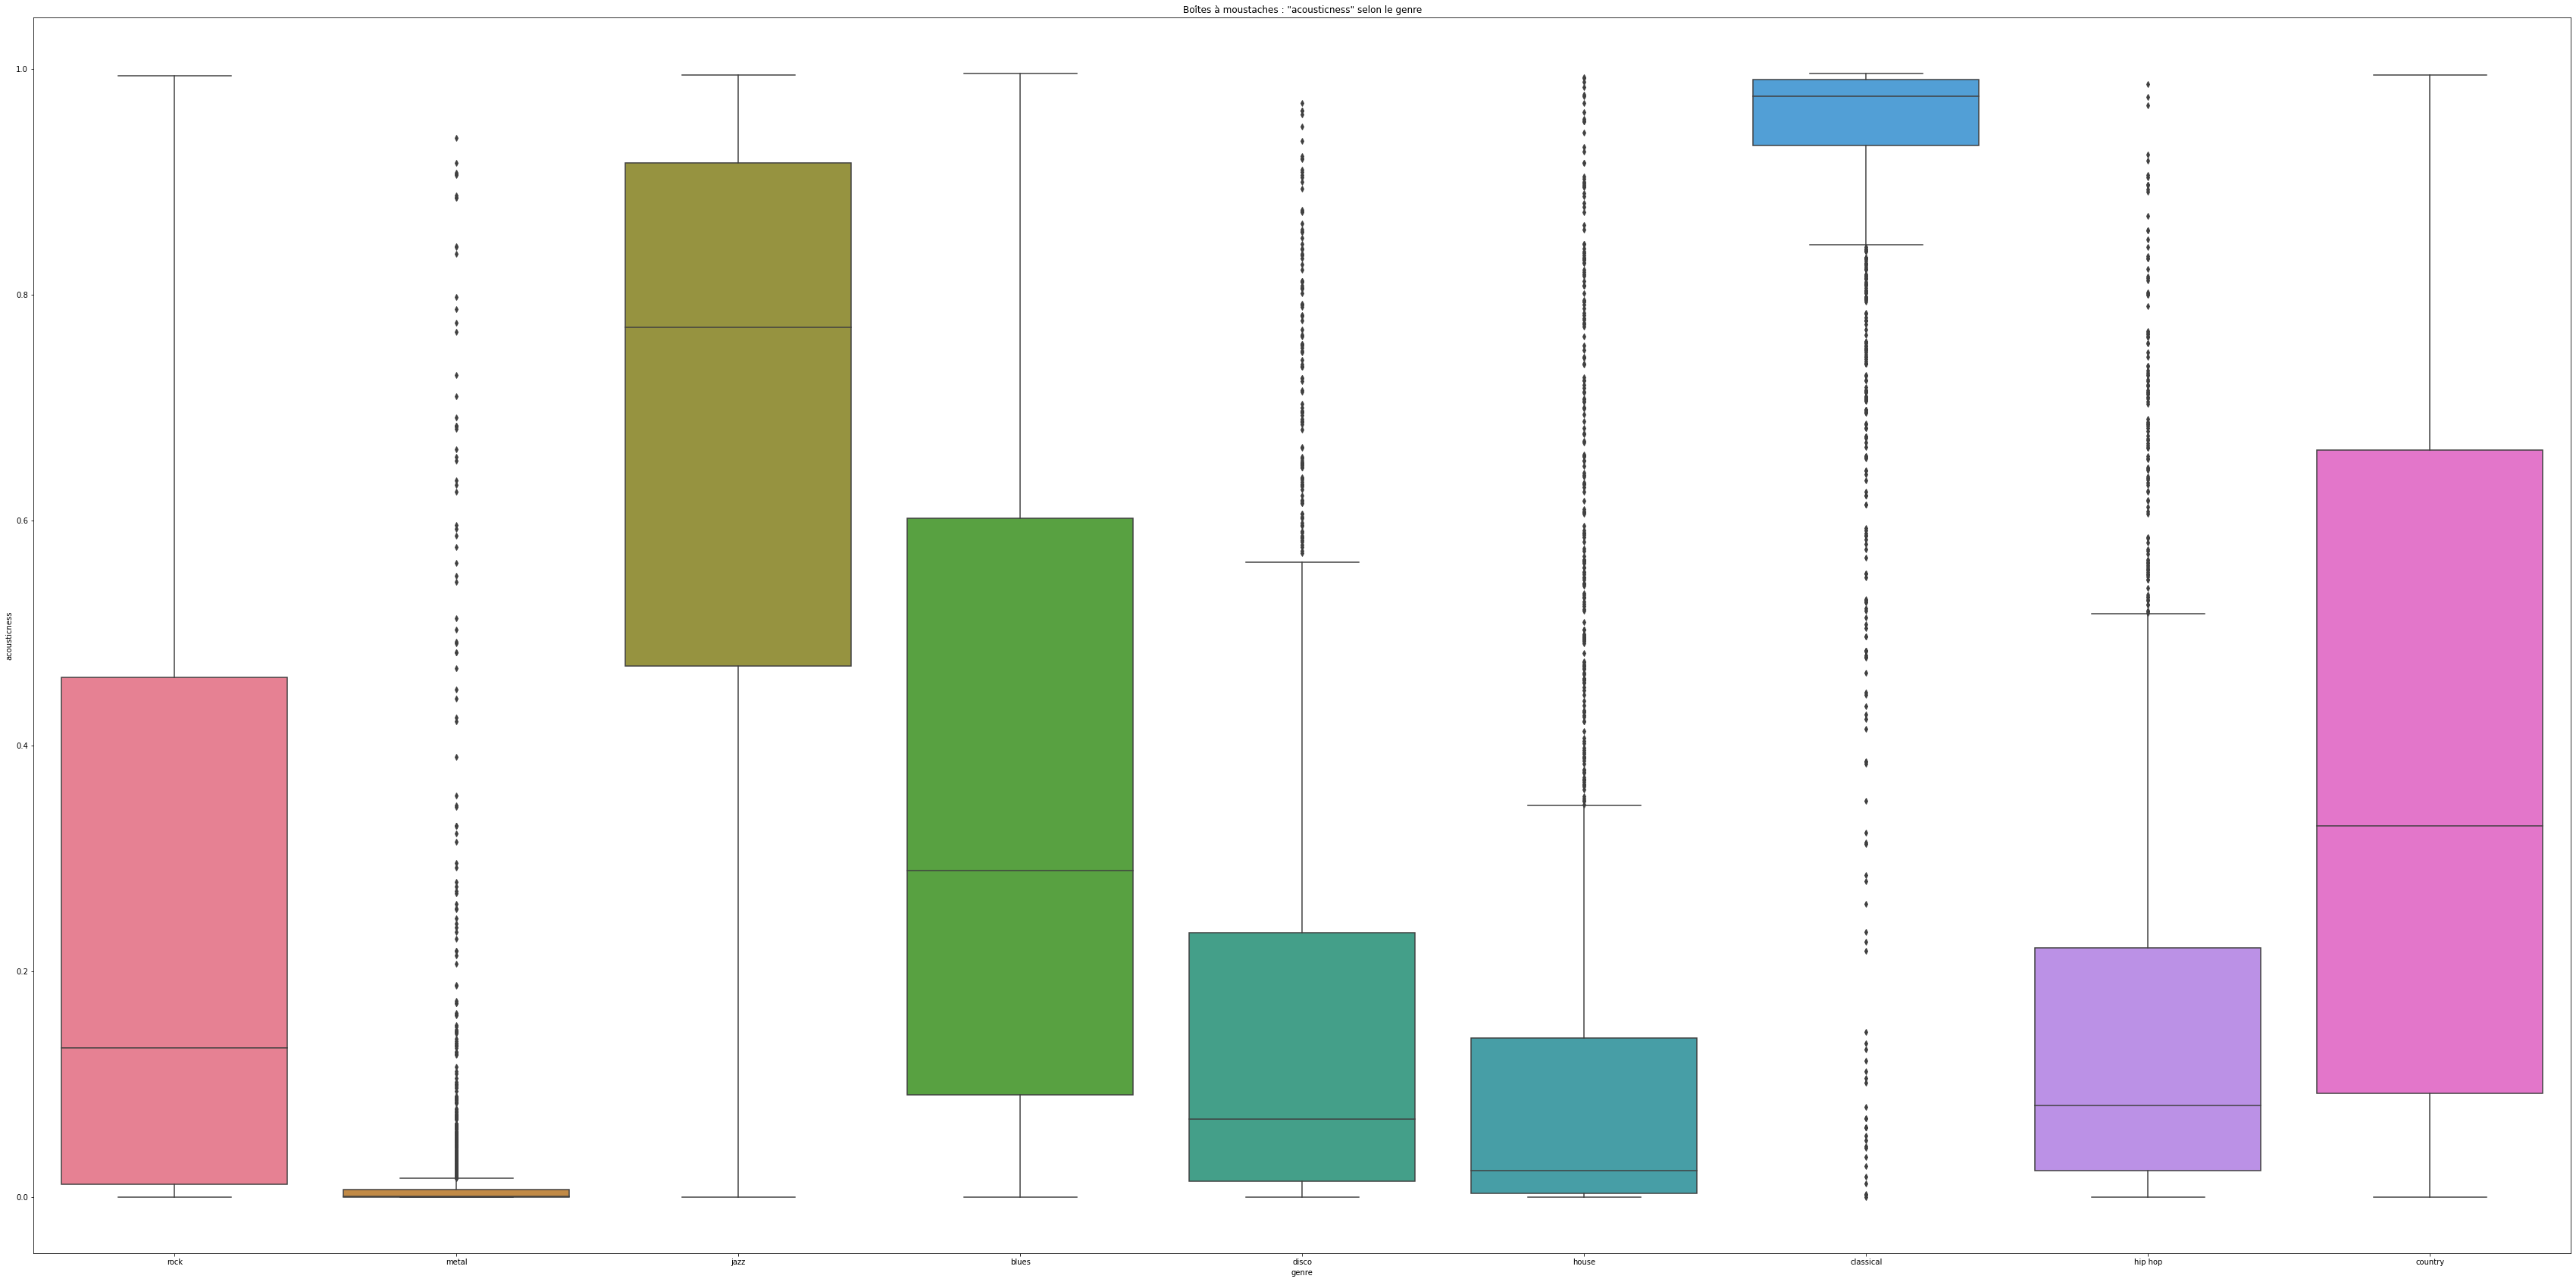

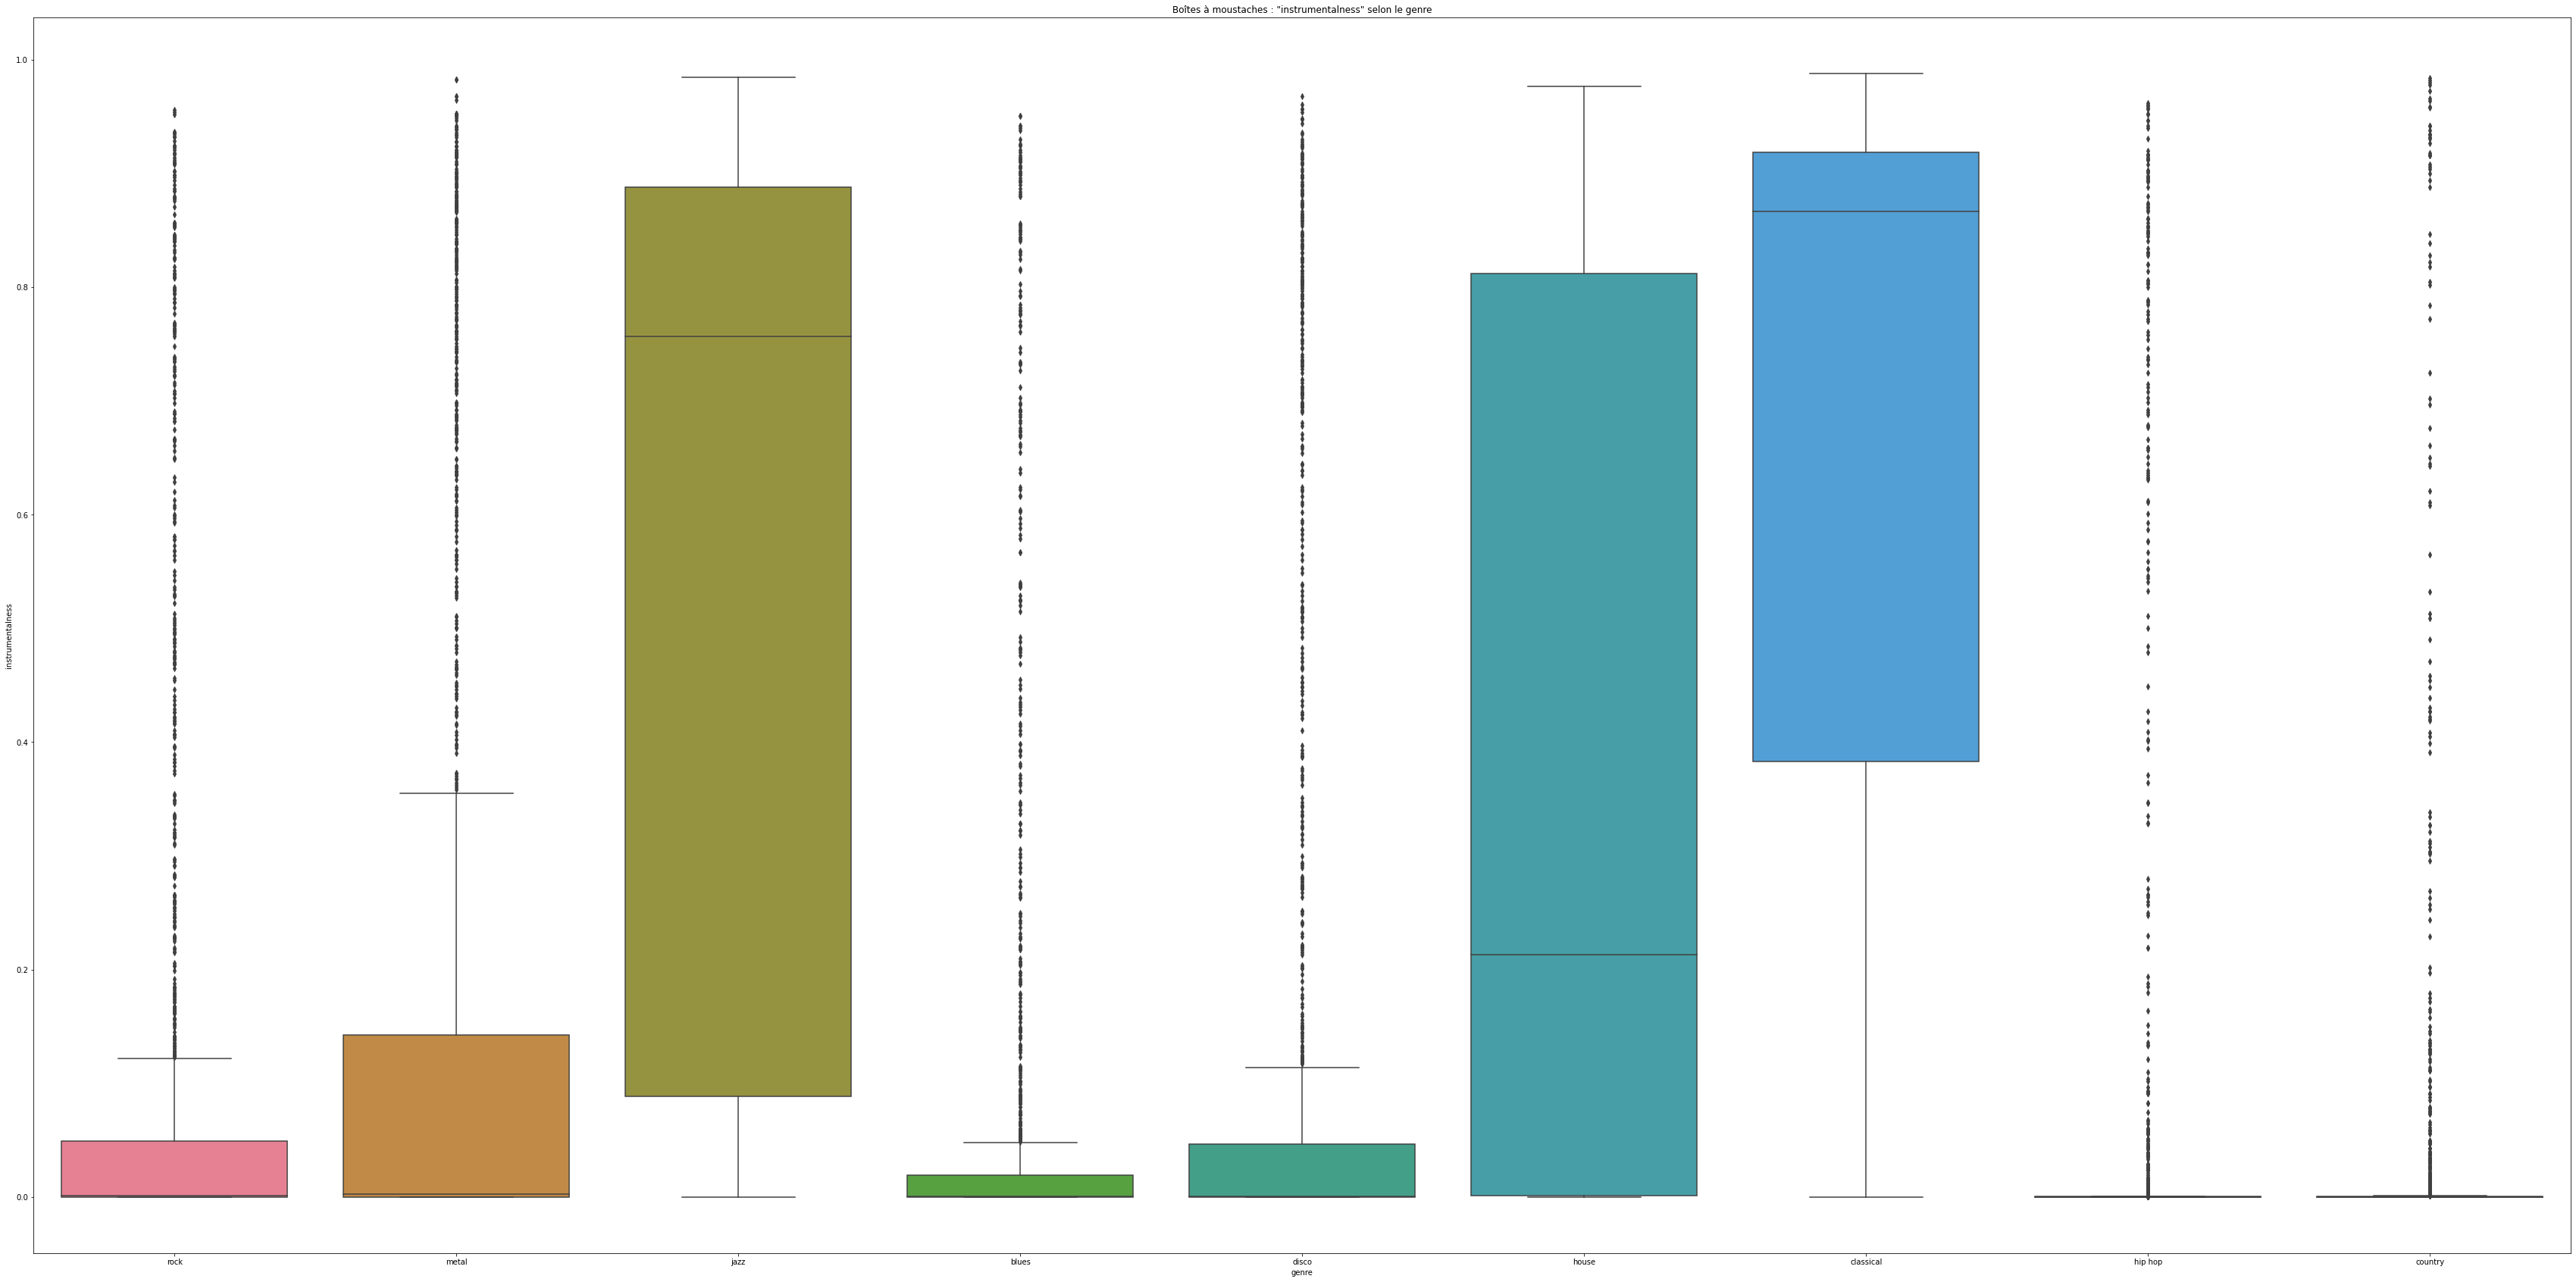

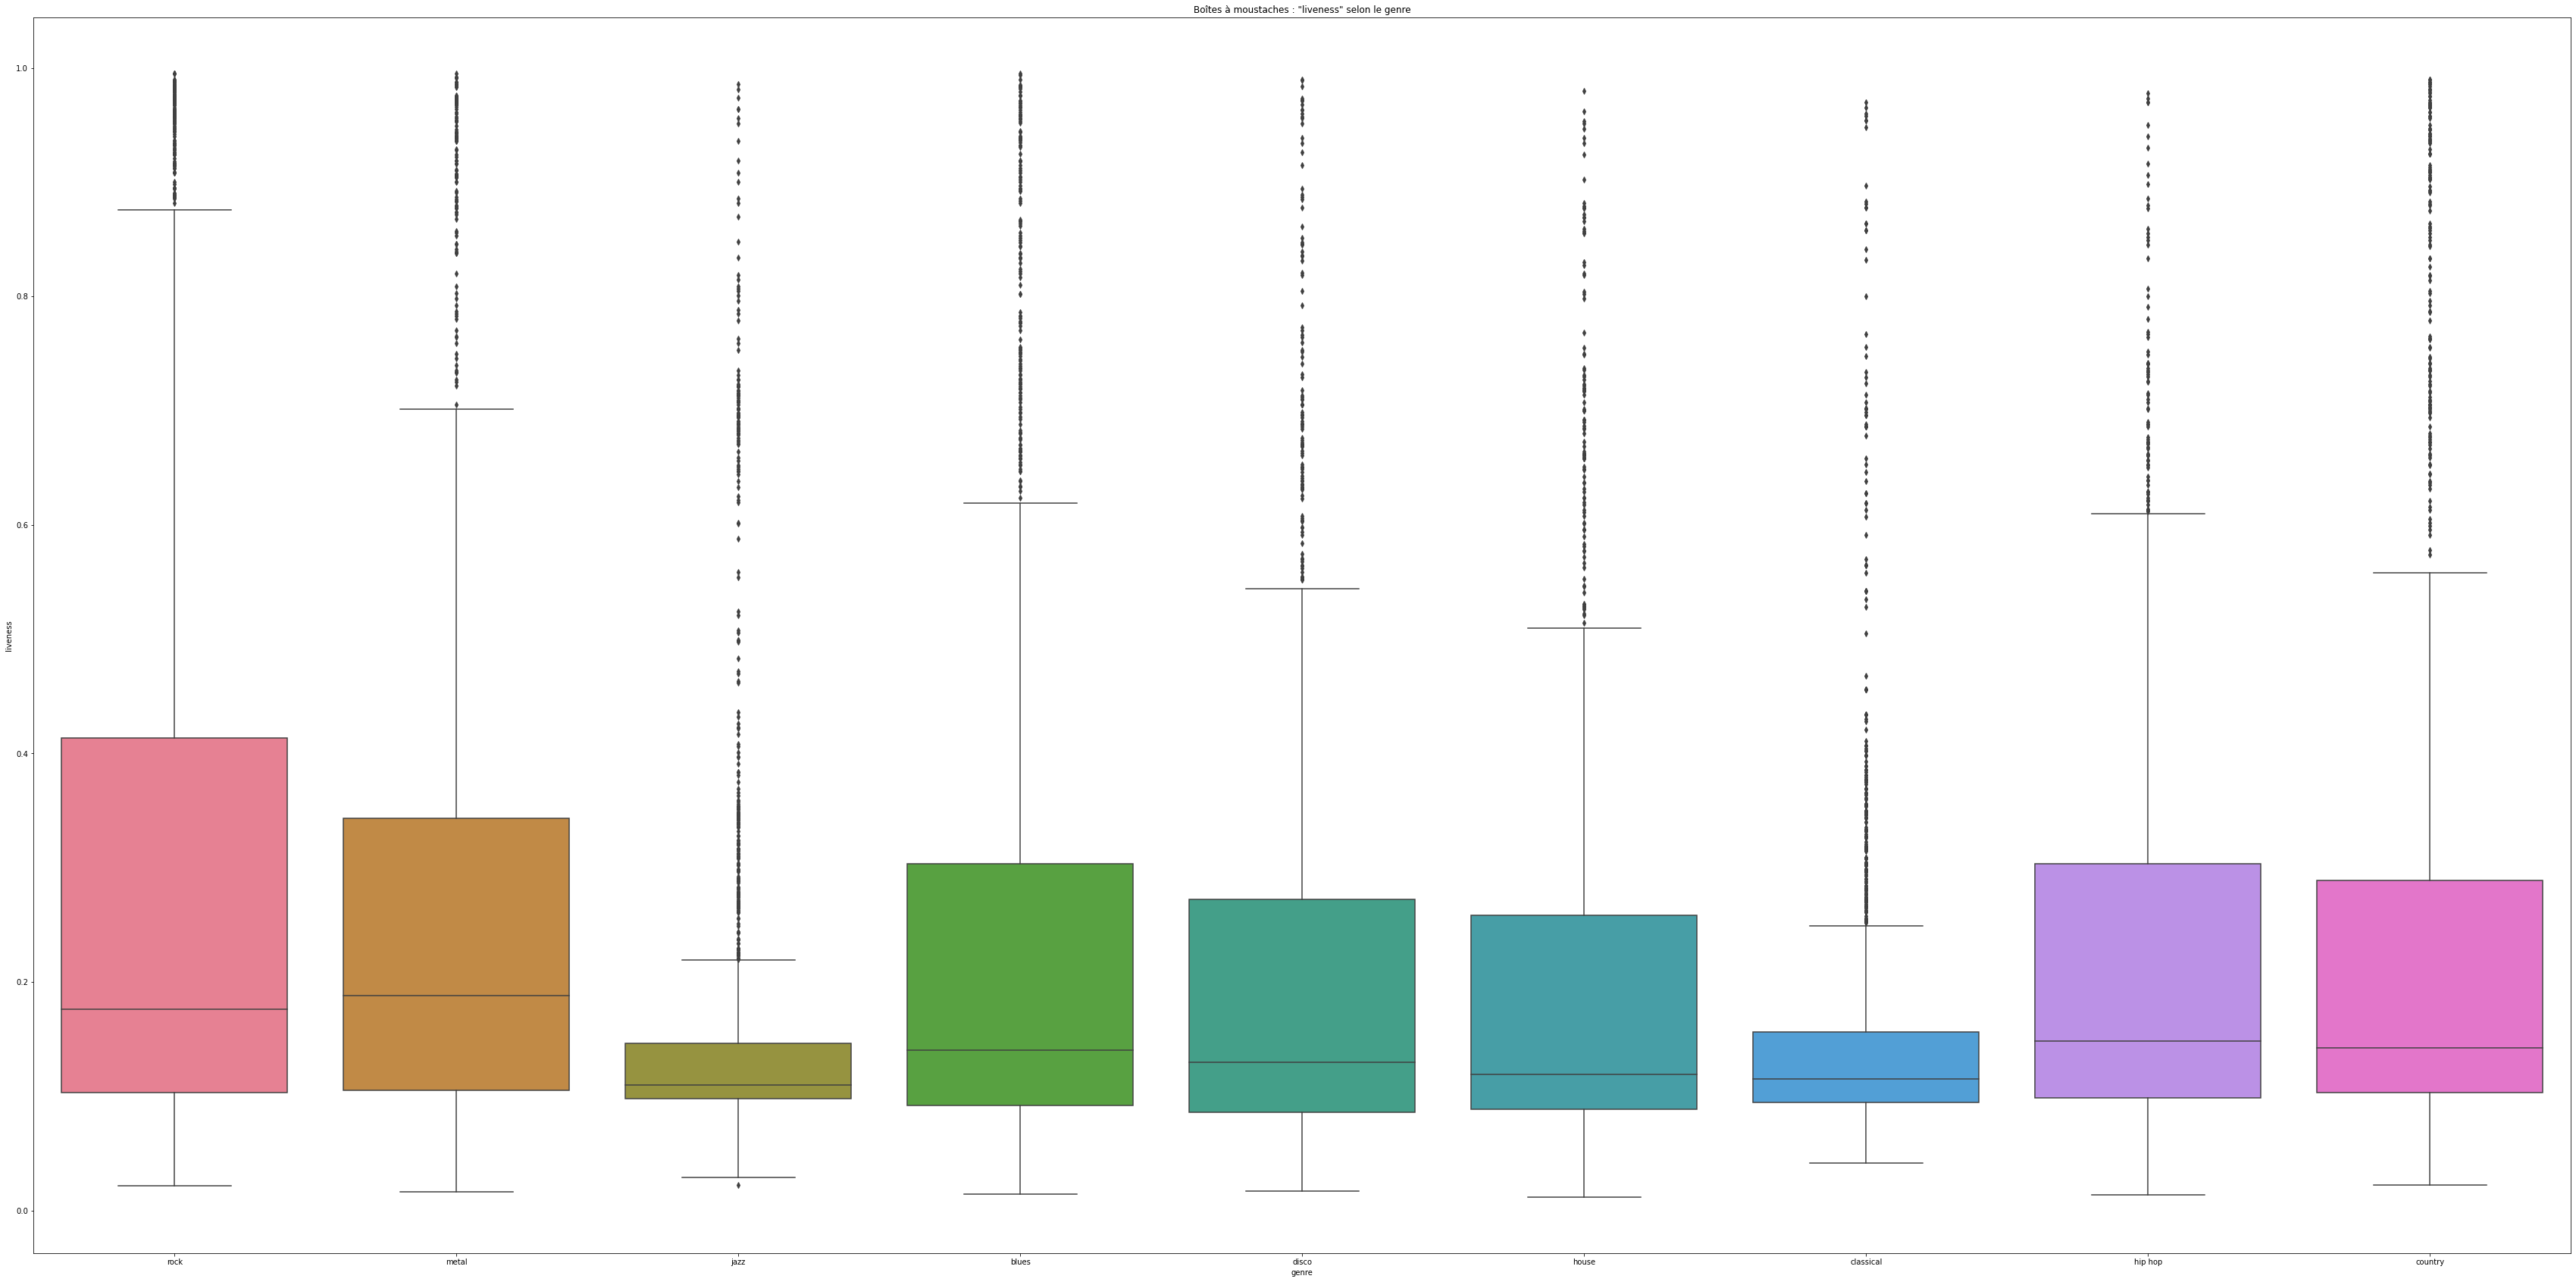

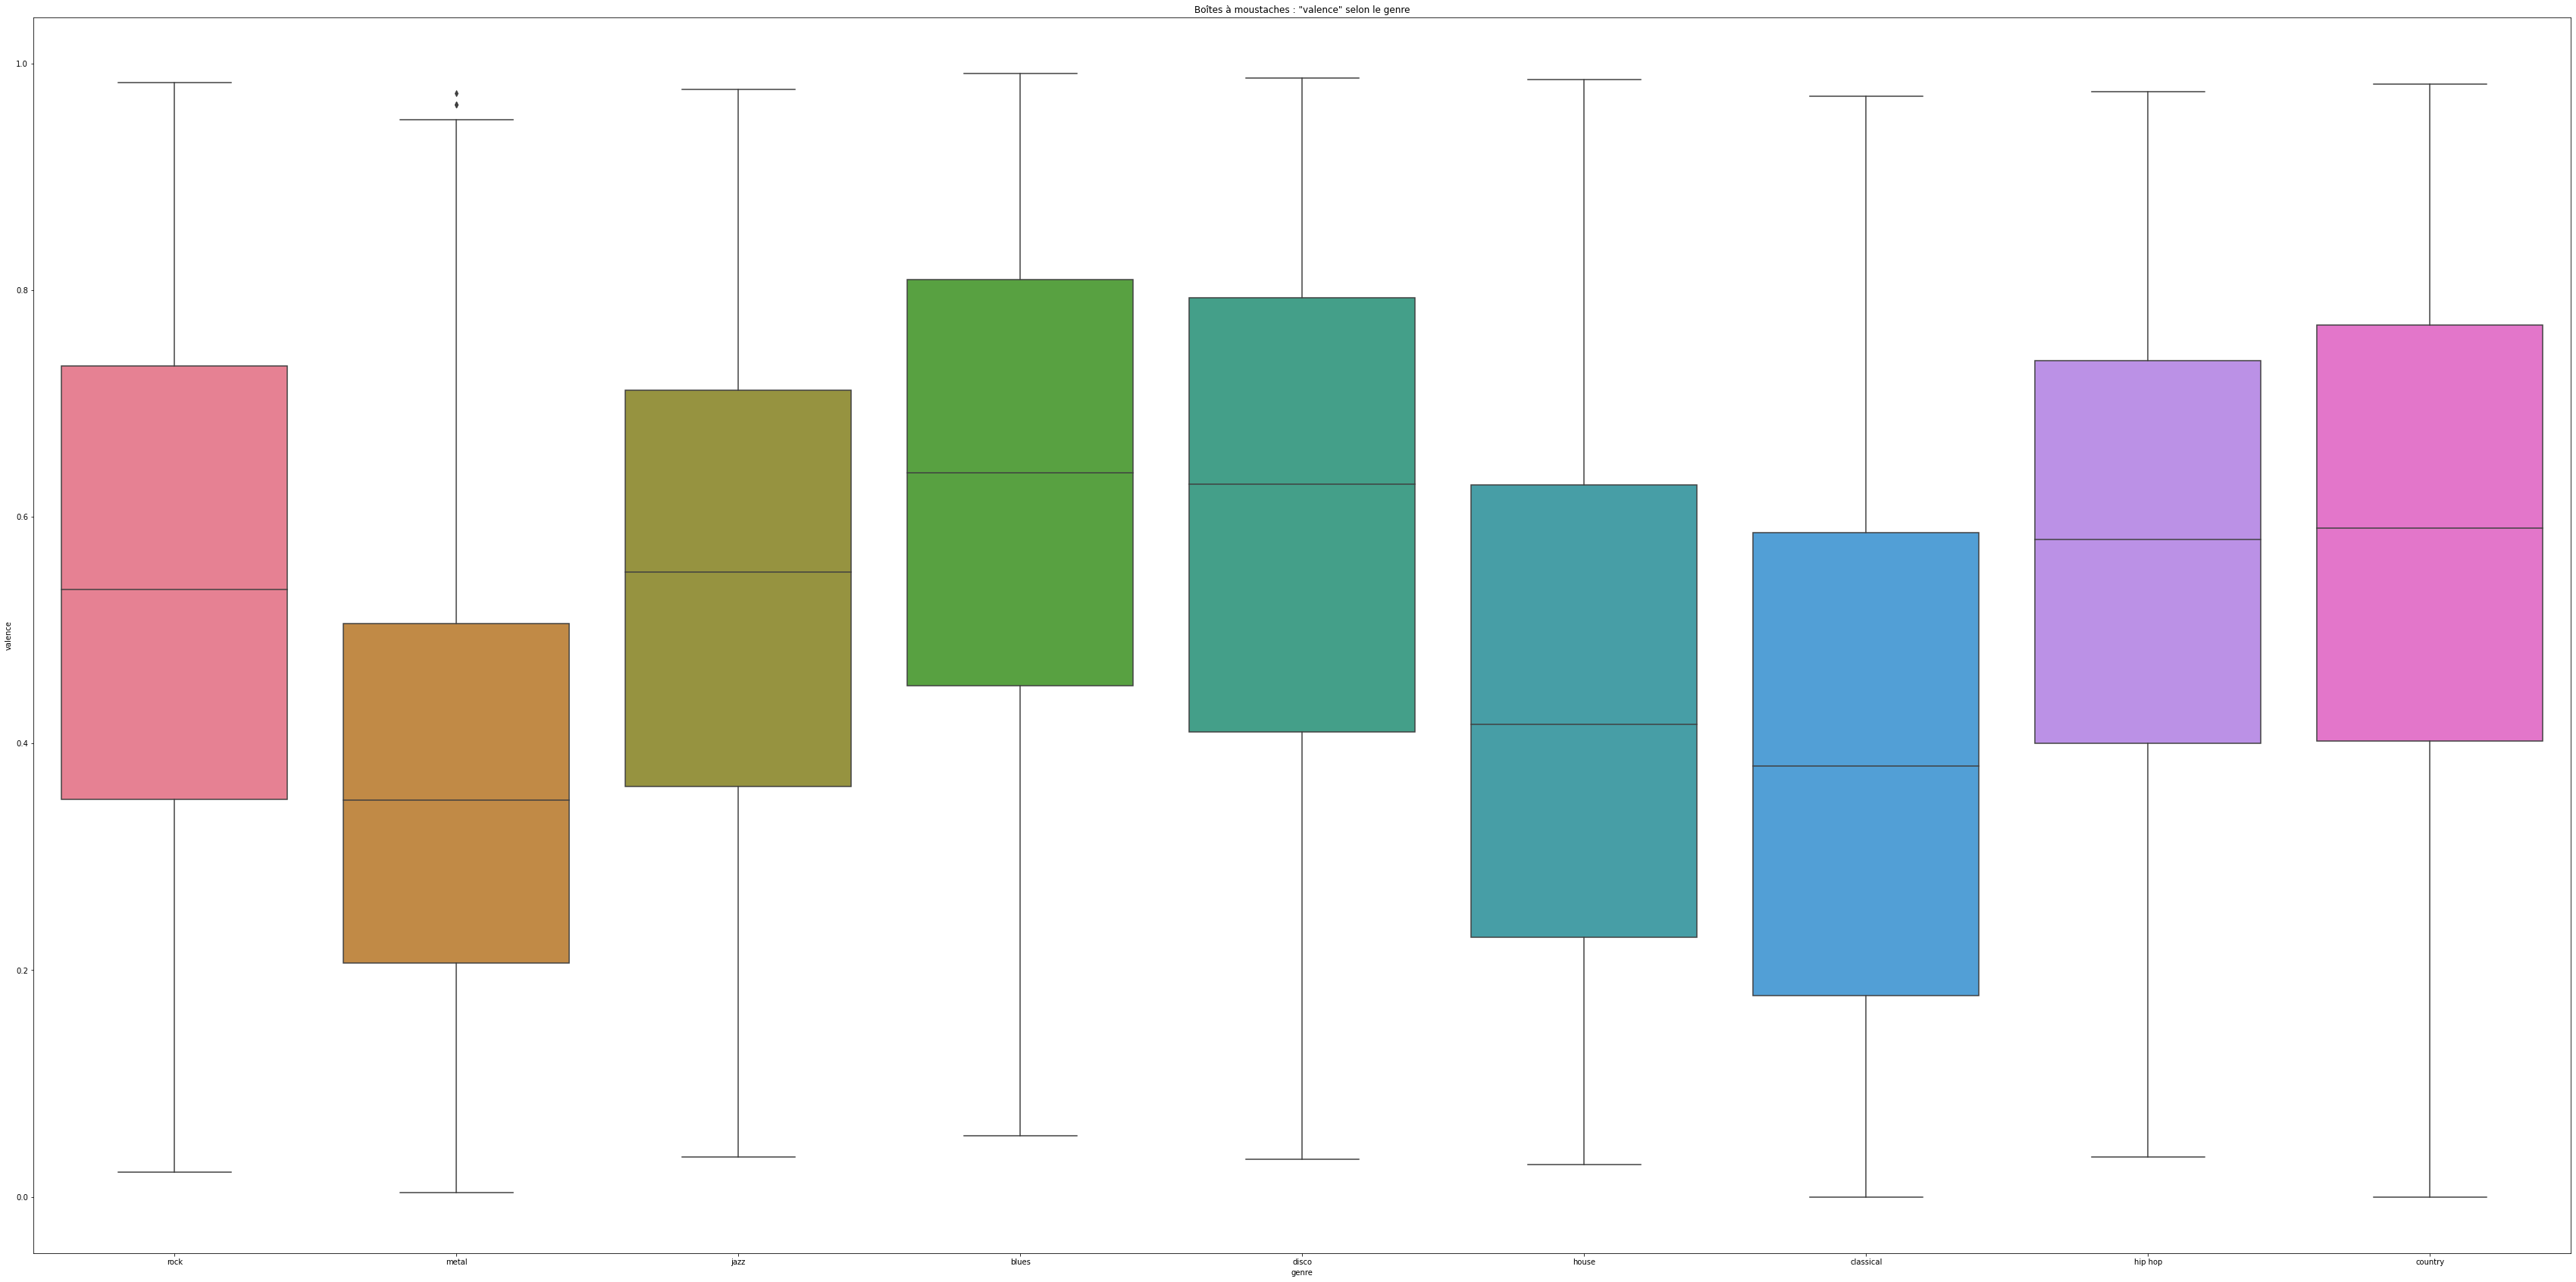

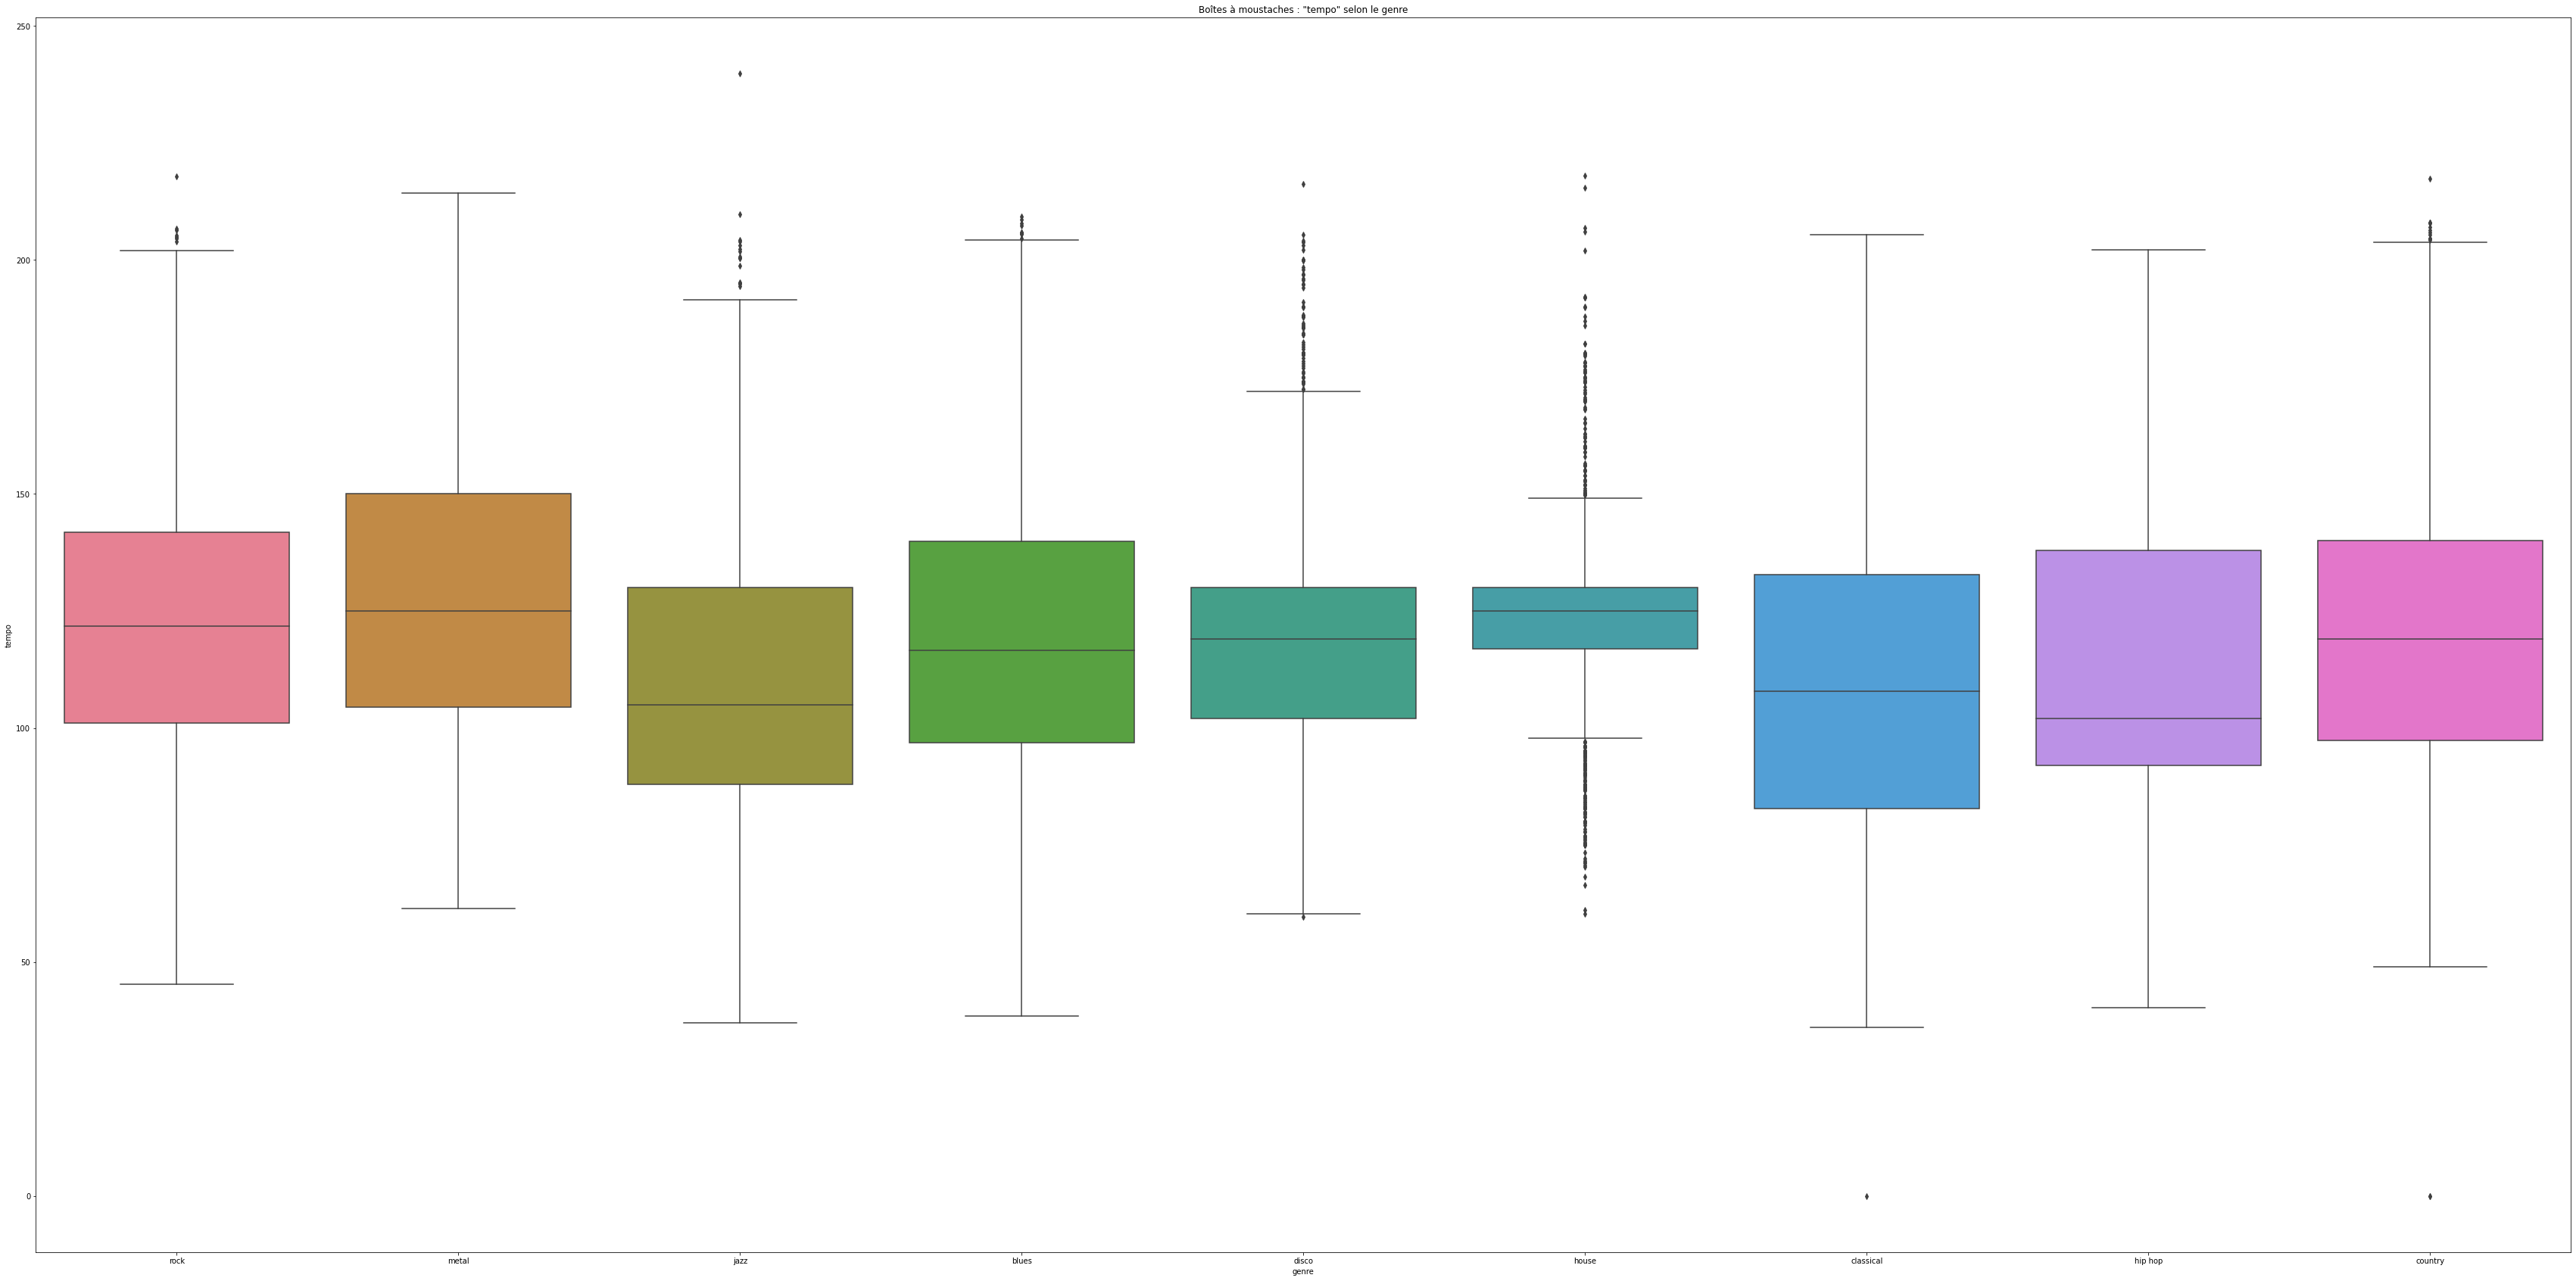

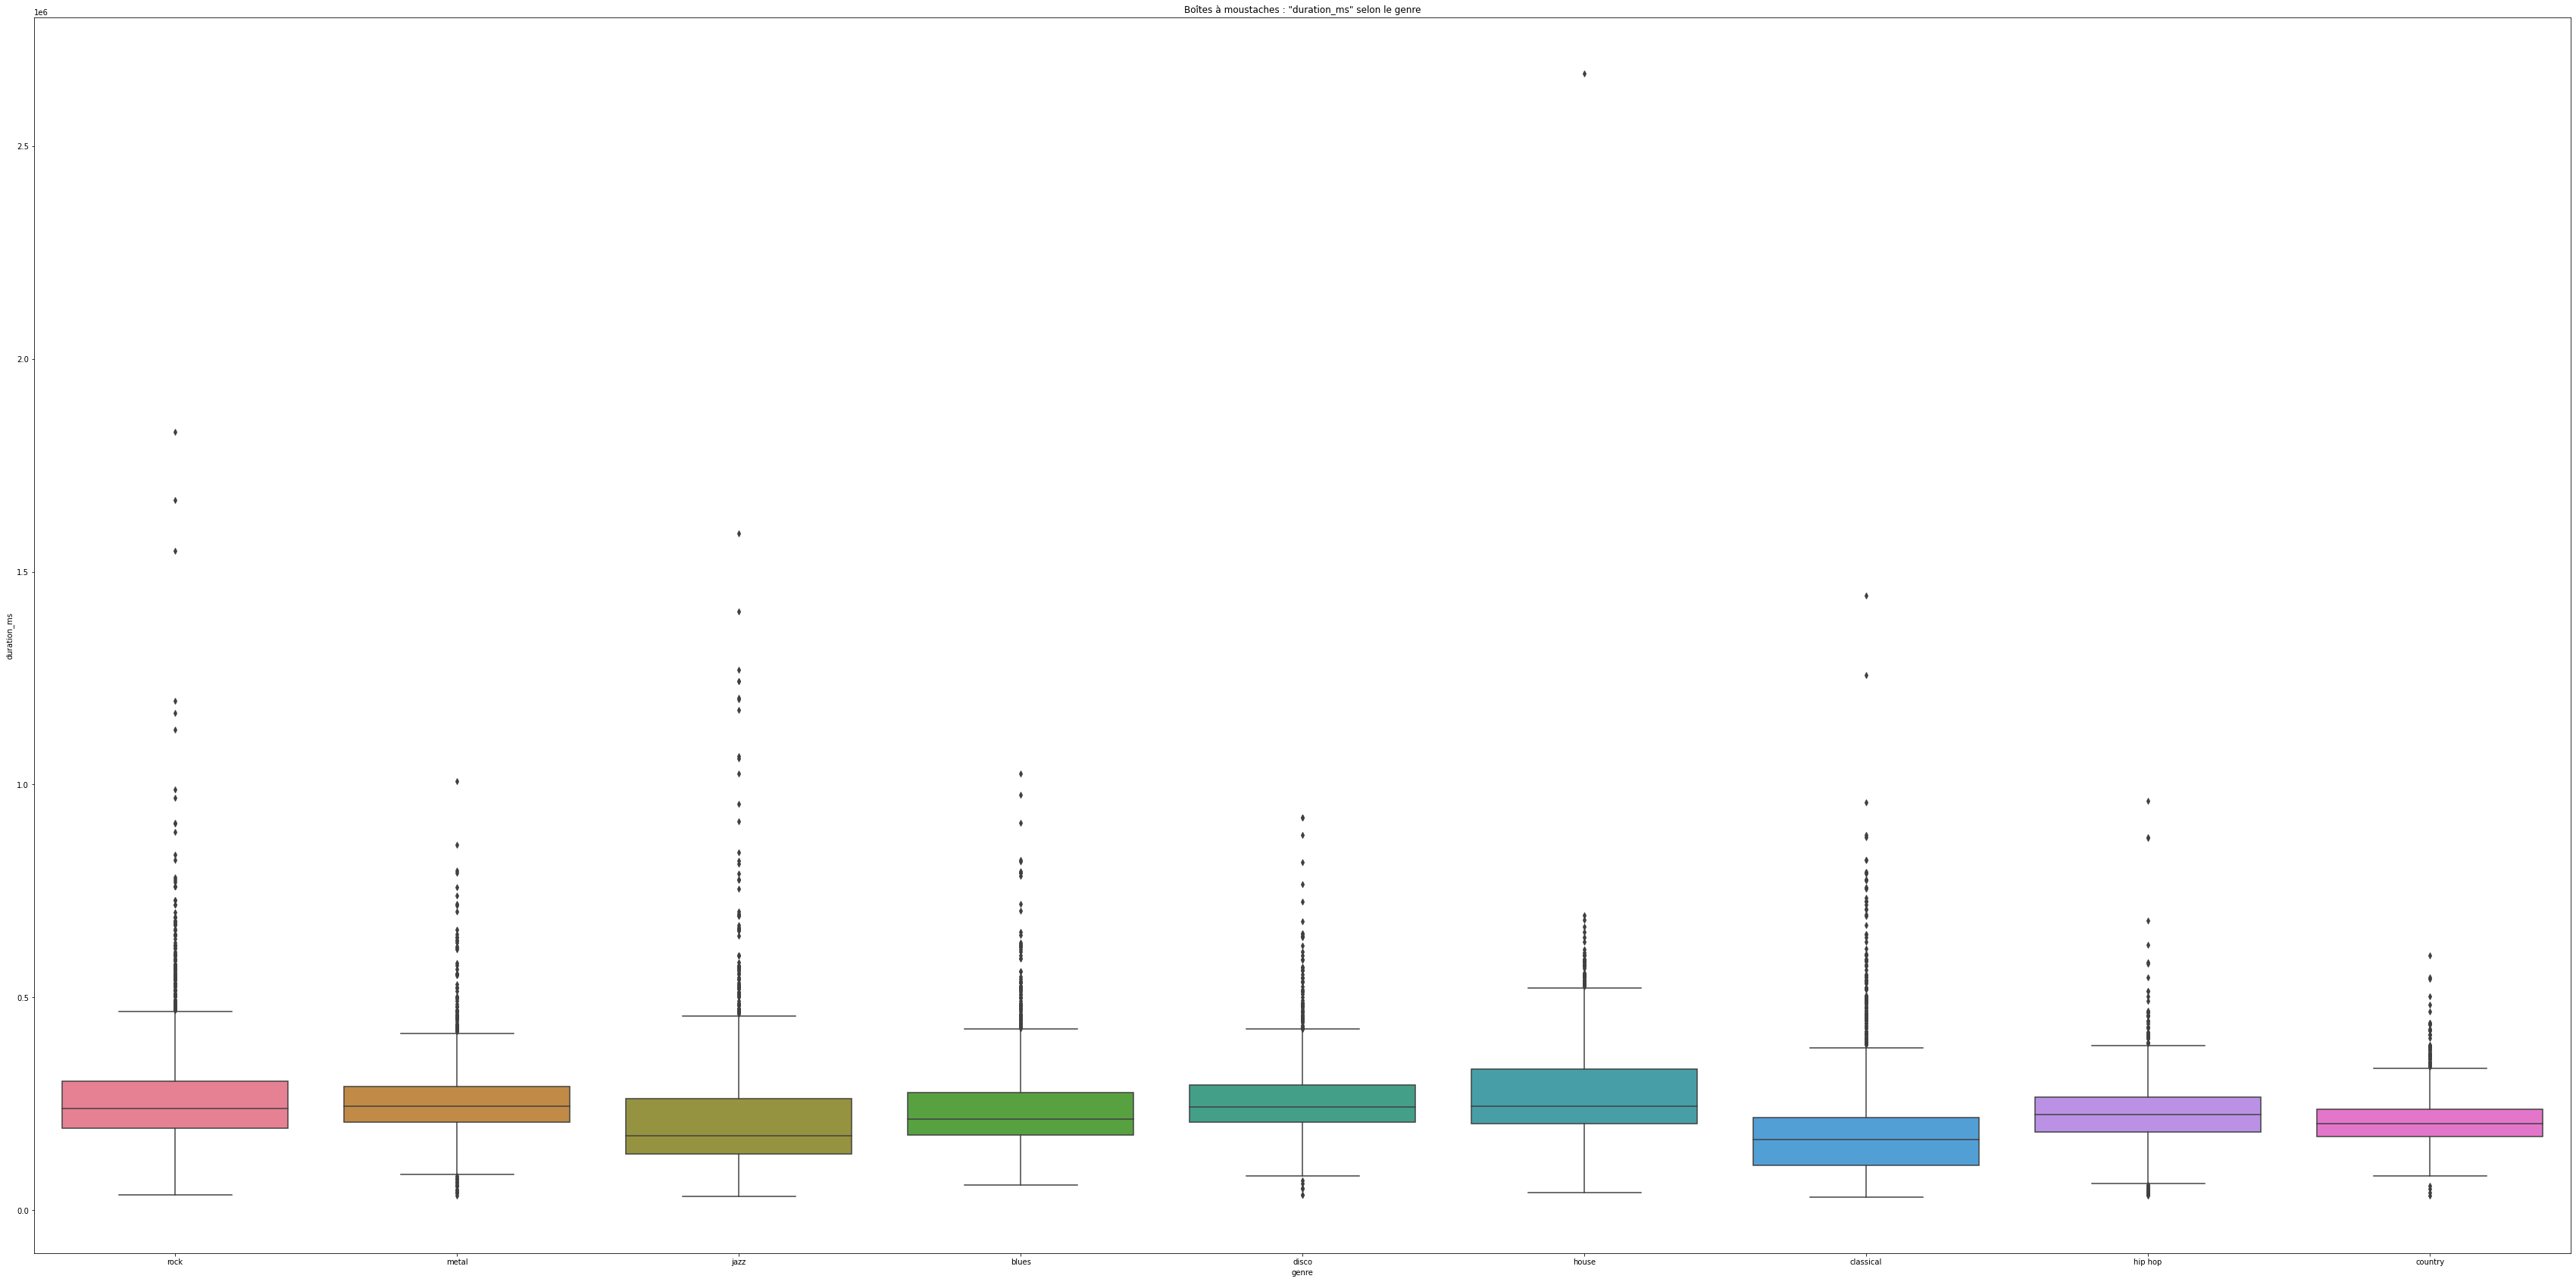

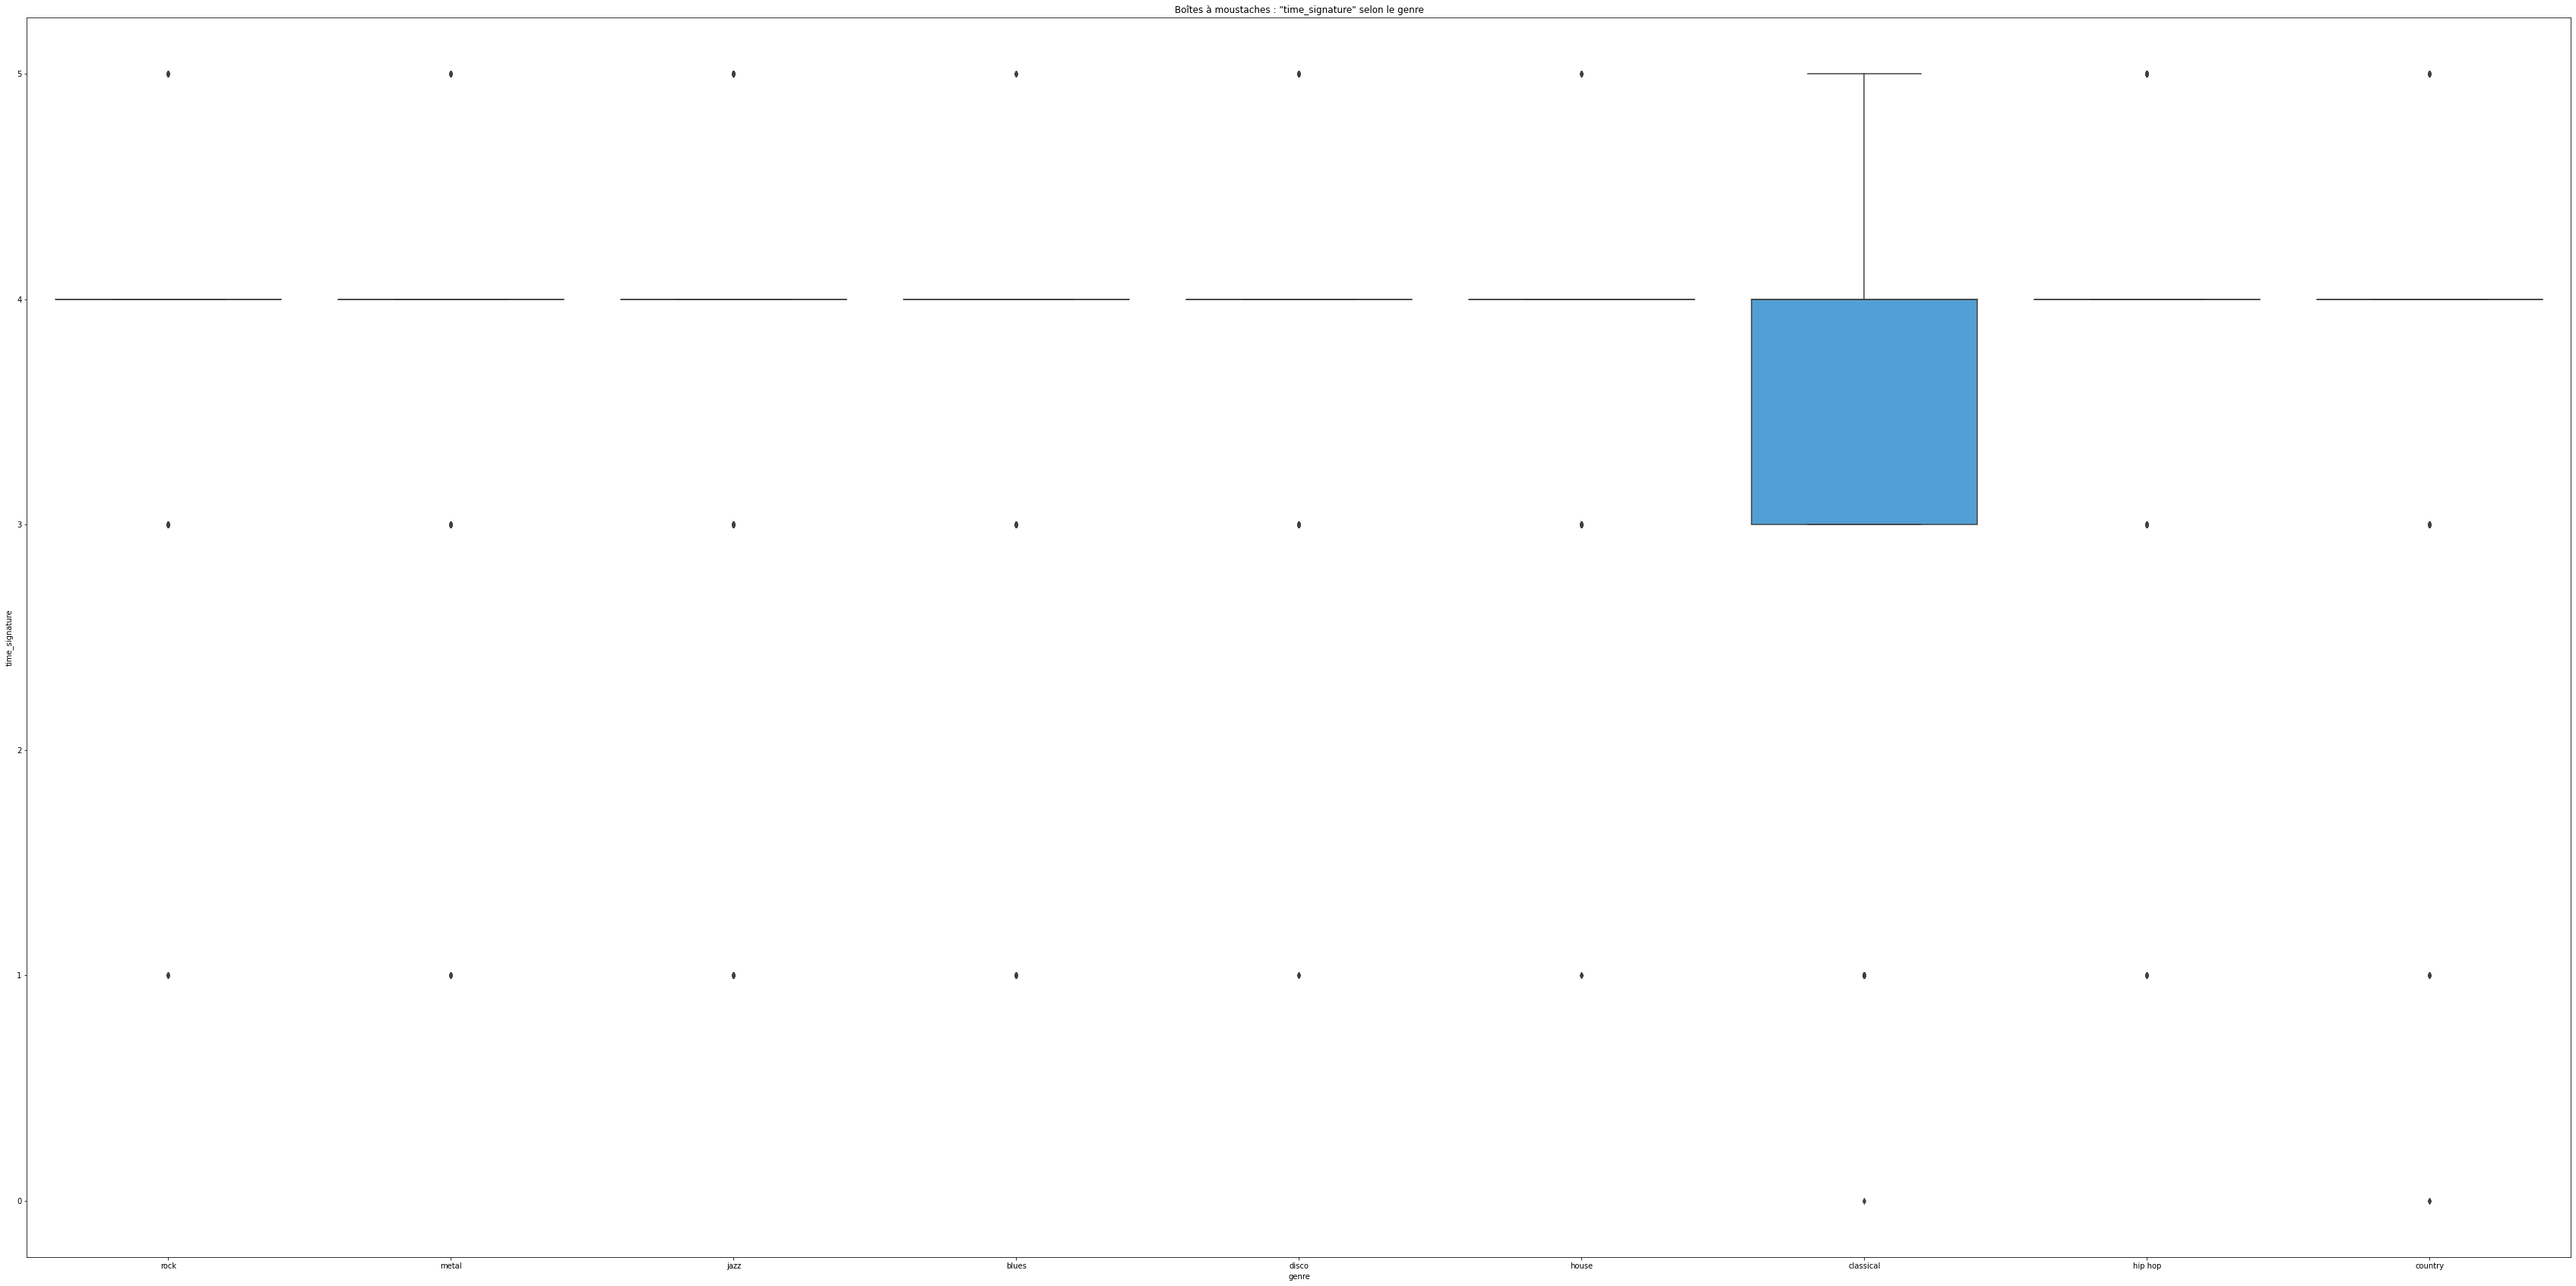

In [225]:
# Pour que ce soit plus visuel, on peut plot des boîtes à moustaches 

import seaborn as sns
ax = sns.boxplot(y="danceability", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "danceability" selon le genre', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30);
plt.xlabel("Genre", fontsize = 35)
plt.ylabel("Danceability", fontsize = 35)
plt.show()

ax = sns.boxplot(y="energy", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "energy" selon le genre')
plt.show()

ax = sns.boxplot(y="key", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "key" selon le genre')
plt.show()

ax = sns.boxplot(y="loudness", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "loudness" selon le genre')
plt.show()

#Pas pertinent de plot mode car ne prend que très peu de valeurs différentes.
ax = sns.boxplot(y="mode", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "mode" selon le genre')
plt.show()

ax = sns.boxplot(y="speechiness", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "speechiness" selon le genre')
plt.show()

ax = sns.boxplot(y="acousticness", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "acousticness" selon le genre')
plt.show()

ax = sns.boxplot(y="instrumentalness", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "instrumentalness" selon le genre')
plt.show()

ax = sns.boxplot(y="liveness", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "liveness" selon le genre')
plt.show()

ax = sns.boxplot(y="valence", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "valence" selon le genre')
plt.show()

ax = sns.boxplot(y="tempo", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "tempo" selon le genre')
plt.show()

ax = sns.boxplot(y="duration_ms", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "duration_ms" selon le genre')
plt.show()


ax = sns.boxplot(y="time_signature", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "time_signature" selon le genre')
plt.show()

Certaines boîtes montrent des dispersiond très différentes au niveau des caractéristiques, en fonction du genre (energy, danceability, instrumentalness, accousticness) tandis que d'autres caractéristique ne diffèrent que très peu. Par exemple, key, mode, time-signature, duration : on pouvait s'y attendre car ce ne sont pas des caractéristiques donnant une "note" entre 0 et 1, mais des indicateurs ne prenant que peu de valeurs différentes. D'autres caractéristiques qui auraient pu montrer une dispersion très différente affichent une distribution finalement assez similaire selon le genre, comme le tempo, liveness, ce qu'il est intéressant de noter. 

Corrélation entre les genres :

On peut essayer de regarder à quel point deux genres sont similaires, afin d'établier une "échelle" de proximité entre les genres. On regarde la corrélation des genres en fonction de la moyenne de leur features.


[9.89621215e-01 9.15704971e-03 9.33738771e-04 1.95785945e-04
 7.51091709e-05]


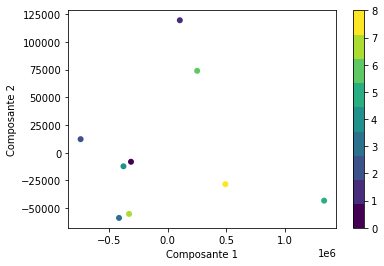

In [79]:
pca = PCA(n_components=5)
principal_components_features = pca.fit(df_genres_describe)
exp_variance = pca.explained_variance_ratio_
print(exp_variance)

genres_to_labels_describe = {genre : idx for idx,genre in enumerate(df_genres_describe.index.unique())}
labels = [genres_to_labels_describe[genre] for genre in df_genres_describe.index]

df_genres_describe['labels'] = labels


genres_projected = pca.fit_transform(df_genres_describe) 
plt.scatter(genres_projected[:, 0], genres_projected[:, 1],
            c=df_genres_describe.labels, edgecolor='none', alpha=5,
            cmap=plt.cm.get_cmap('viridis', 9))
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.colorbar();

#### Corrélation entre les différentes caractéristiques :

On veut éviter les caractéristiques fortement corrélées pour éviter que ces dernières soit redondantes. En effet  garder uniquement les features pertinentes simplifie le modèle et évite l'overfitting, et permet également des temps de calculs moins long.

In [63]:
#On observe la corrélation entre les features 
corr_metrics = df_track.corr(method='pearson')

#Pour que ce soit plus visuel : plus la corrélation entre deux features est importante, plus la case est foncée
corr_metrics.style.background_gradient()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
danceability,1.000000,0.124636,0.016788,0.218414,-0.071313,0.164990,-0.228194,-0.148524,-0.189146,0.463253,-0.109292,-0.087199,0.186730
energy,0.124636,1.000000,0.030672,0.846501,-0.070838,0.209637,-0.802483,-0.377797,0.210354,0.168035,0.223923,0.190668,0.231023
key,0.016788,0.030672,1.000000,0.021730,-0.161971,0.021667,-0.027739,-0.011184,-0.002169,0.012947,0.000087,0.007615,0.007098
loudness,0.218414,0.846501,0.021730,1.000000,-0.041942,0.195482,-0.726380,-0.522489,0.140895,0.136395,0.184344,0.155213,0.205515
mode,-0.071313,-0.070838,-0.161971,-0.041942,1.000000,-0.073396,0.089442,-0.048148,0.033401,0.020900,0.017605,-0.039927,-0.037598
speechiness,0.164990,0.209637,0.021667,0.195482,-0.073396,1.000000,-0.184934,-0.200132,0.122657,0.036995,0.025177,-0.029722,0.058947
acousticness,-0.228194,-0.802483,-0.027739,-0.726380,0.089442,-0.184934,1.000000,0.366671,-0.103642,-0.090754,-0.180867,-0.205048,-0.228475
instrumentalness,-0.148524,-0.377797,-0.011184,-0.522489,-0.048148,-0.200132,0.366671,1.000000,-0.132310,-0.172563,-0.075360,-0.014211,-0.093897
liveness,-0.189146,0.210354,-0.002169,0.140895,0.033401,0.122657,-0.103642,-0.132310,1.000000,-0.054582,0.044034,0.133931,0.015189
valence,0.463253,0.168035,0.012947,0.136395,0.020900,0.036995,-0.090754,-0.172563,-0.054582,1.000000,0.061465,-0.166387,0.113902


Ici il n'y a pas de corrélation majeure entre les features, on peut donc conserver ces dernières qui restent pertinentes.

### Normalisation des premières données :

Comme mentionné précédemment, il peut être particulièrement utile de simplifier nos modèles et d'utiliser aussi peu de fonctionnalités que nécessaire pour obtenir le meilleur résultat. Comme nous n'avons pas trouvé de corrélations particulièrement fortes entre nos fonctionnalités, nous pouvons à la place utiliser une approche commune pour réduire le nombre de fonctionnalités : l'analyse en composants principaux (ACP).
L'ACP nous permet en effet de déterminer la contribution relative de chaque caractéristique de nos données à la variance entre les différents genres.

Cependant, étant donné que l'ACP utilise la variance absolue d'une fonction, les caractéristiques avec des plages de valeurs larges vont surpasser et biaiser l'algorithme par rapport aux autres caractéristiques. Normaliser les données est donc une étape importante, on utilise pour cela la standardisation. 

In [80]:
from sklearn.preprocessing import StandardScaler

autoscaler = StandardScaler()

#On enlève les colonnes qui ne sont pas numériques (et donc qu'il n'est pas nécessaire de normaliser)
df_track_features = df_track.drop(['track_name', 'track_artists', 'genre'], axis=1)

#On normalise
normalized_features = autoscaler.fit_transform(df_track_features)

In [81]:
#On remplace les éventuels NaN par 0
normalized_features = np.nan_to_num(normalized_features)

#On vérifie qu'il n'y a plus de NaN
np.isnan(normalized_features).sum()

0

#### Normalized_df_track = df_track normalisé

In [82]:
#On reconstruit un "beau" DataFrame et on rajoute les colonnes qu'il n'était pas nécessaire de normaliser

normalized_df_track = pd.DataFrame(normalized_features, index=df_track_features.index, columns=df_track_features.columns)
normalized_df_track['track_name'] = df_track['track_name']
normalized_df_track['track_artists'] = df_track['track_artists']
normalized_df_track['genre'] = df_track['genre']

#normalized_df_track

### ACP de Normalized_df_track

In [83]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
principal_components_features = pca.fit(normalized_features)
exp_variance = pca.explained_variance_ratio_
exp_variance


array([0.25262265, 0.12472353, 0.0926487 , 0.08207891, 0.07992753])

Les 5 premiers coefficients de l'ACP montrent que ces features du df_track permettent d'expliquer près de 62% de la variance, ce qui constitue un premier résultat intéressant.

Afin d'améliorer notre prédiction, considérer des features bien choisie en exploitant les deux autres dataset est essentiel. Nous allons donc nous concentrer sur ces derniers.

### Dataset pitches

Les pitches et timbres se lisent par groupe de 12 : il s'agit d'un vecteur de 12 coefficients. 
Il est donc pertinent de comparer les pitches entre elles ou timbres entre eux coefficient par coefficient.
On peut également calculer les statistiques du vecteur (chromagramme, fonction de timbre), pour nous donner des informations sur le chromagramme/la fonction de timbre "type" selon le genre.

Pour plus de clarté, on va renommer les colonnes du dataframe.

Tout d'abord on normalise les deux bases :

In [84]:
#On normalise df_pitches
normalized_pitches = autoscaler.fit_transform(df_pitches.drop(['genre'], axis=1))

#On remplace les éventuels NaN par 0
normalized_pitches = np.nan_to_num(normalized_pitches)

#On vérifie qu'il n'y a plus de NaN
np.isnan(normalized_pitches).sum()

0

In [85]:
#On reconstruit un "beau" DataFrame et on rajoute les colonnes qu'il n'était pas nécessaire de normaliser

normalized_pitches = pd.DataFrame(normalized_pitches, index= df_pitches.index)
normalized_pitches['genre'] = df_pitches['genre']
#normalized_pitches

In [86]:
#On normalise df_timbres
normalized_timbres = autoscaler.fit_transform(df_timbres.drop(['genre'], axis=1))

#On remplace les éventuels NaN par 0
normalized_timbres = np.nan_to_num(normalized_timbres)

#On vérifie qu'il n'y a plus de NaN
np.isnan(normalized_timbres).sum()


0

In [226]:
#On reconstruit un "beau" DataFrame et on rajoute les colonnes qu'il n'était pas nécessaire de normaliser

normalized_timbres = pd.DataFrame(normalized_timbres, index= df_timbres.index)
normalized_timbres['genre'] = df_timbres['genre']
normalized_timbres

,timbre0_idx1,timbre0_idx2,timbre0_idx3,timbre0_idx4,timbre0_idx5,timbre0_idx6,timbre0_idx7,timbre0_idx8,timbre0_idx9,timbre0_idx10,...,timbre124_idx4,timbre124_idx5,timbre124_idx6,timbre124_idx7,timbre124_idx8,timbre124_idx9,timbre124_idx10,timbre124_idx11,timbre124_idx12,genre
2wiA6eP7rBktnxmjgX8g7U,-0.615493,0.545173,-0.025551,0.206187,0.261468,-0.371327,-0.088993,0.199932,-0.239343,-0.437682,...,-0.136771,-0.071739,-0.536746,1.402958,0.270067,-0.764831,0.844401,0.649657,0.150322,rock
48xD8fTt37etYF52AJBiXF,-0.621217,0.567382,0.014861,0.237181,0.333963,-0.366310,-0.125032,0.278706,-0.223695,-0.442360,...,-0.068180,-1.671918,-0.080684,-2.001556,-0.421553,-0.582865,-0.012558,0.990158,-2.708371,rock
74wIEdRJGZR5aaKu2XnREO,-0.621217,0.567382,0.014861,0.237181,0.333963,-0.366310,-0.125032,0.278706,-0.223695,-0.442360,...,-0.049801,-0.041201,-0.196135,0.610211,0.156367,0.803833,-0.768301,0.748866,0.622235,rock
25YlltWXRb9k7KbrEBRuhJ,0.579412,0.316370,-1.570265,2.834851,-1.416897,-1.122130,-2.230693,-0.141137,0.500372,-0.439041,...,-0.818181,0.595387,-0.741634,1.128530,-0.394913,-0.316207,0.768024,0.060821,-1.457631,rock
2CczZm7lbN6DEeOvct2K6s,0.939028,0.226587,1.370809,0.736262,0.642394,0.617290,-0.722361,-0.192903,2.414913,-1.432180,...,0.184929,0.687153,0.398226,1.300567,0.491305,-0.717875,0.021270,0.762070,0.329290,rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CMGAu0krhuwn7BKpjwLz0,-0.621217,0.567382,0.014861,0.237181,0.333963,-0.366310,-0.125032,0.278706,-0.223695,-0.442360,...,-0.319223,-1.740796,0.462181,-0.334664,-3.021215,0.398749,0.333215,-1.725828,0.585969,country
5SzBQvpCZGuWP3FcLlUtVd,-0.621217,0.567382,0.014861,0.237181,0.333963,-0.366310,-0.125032,0.278706,-0.223695,-0.442360,...,0.168783,-0.128764,-0.279801,1.751336,1.266924,0.352770,-0.341470,0.820373,-0.547514,country
5d0O0zKttFsO60cXzdQYjX,-0.616038,0.548228,-0.023808,0.210484,0.263080,-0.371446,-0.070079,0.215130,-0.218236,-0.425566,...,-0.644261,-0.811553,0.611016,-1.904291,-0.444480,0.807358,-0.096754,0.375485,-1.790712,country
2a2ohPqiaeLI8jrgVLGqyo,-0.621217,0.567382,0.014861,0.237181,0.333963,-0.366310,-0.125032,0.278706,-0.223695,-0.442360,...,-0.131702,-0.383745,-0.437454,0.506659,0.047156,0.538205,0.937480,0.097481,0.350406,country


On renomme les colonnes des dataframes :

In [88]:
newCols = ["pitch0_idx" + str(k) for k in range(1,13)]
for pitchIdx in range(1,125):
    newCols.extend([("pitch%d_idx" % pitchIdx) + str(k) for k in range(1,13)])
newCols.extend(['genre'])

normalized_pitches.columns = newCols
#normalized_pitches

In [89]:
newCols = ["timbre0_idx" + str(k) for k in range(1,13)]
for timbreIdx in range(1,125):
    newCols.extend([("timbre%d_idx" % timbreIdx) + str(k) for k in range(1,13)])
newCols.extend(['genre'])

normalized_timbres.columns = newCols
#normalized_timbres

Désormais, on a les 125 premiers chromagrammes de chaque chanson, un chromagramme correspondant aux 12 colonnes commençant par pitchk avec $k \in [[0,124]]$. De même pour les fonctions de timbres.

On rassemble des statistiques sur chaque dimension du chromagramme

In [90]:
df_pitches_reduced = pd.DataFrame(index = df_pitches.index)
for dimChroma in range(1,13):
    filteredCols = ["pitch%d_idx%d" % (pitchIdx, dimChroma) for pitchIdx in range(125)]
    filtered_df = normalized_pitches.filter(items = filteredCols).transpose()
    df_pitches_reduced['chroma%d_mean' % dimChroma] = filtered_df.mean()
    df_pitches_reduced['chroma%d_standard_deviation' % dimChroma] = filtered_df.std()
    df_pitches_reduced['chroma%d_skewness' % dimChroma] = filtered_df.skew()
    df_pitches_reduced['chroma%d_kurtosis' % dimChroma] = filtered_df.kurt()
df_pitches_reduced

,chroma1_mean,chroma1_standard_deviation,chroma1_skewness,chroma1_kurtosis,chroma2_mean,chroma2_standard_deviation,chroma2_skewness,chroma2_kurtosis,chroma3_mean,chroma3_standard_deviation,...,chroma10_skewness,chroma10_kurtosis,chroma11_mean,chroma11_standard_deviation,chroma11_skewness,chroma11_kurtosis,chroma12_mean,chroma12_standard_deviation,chroma12_skewness,chroma12_kurtosis
3kMD2oeKNPwTxolcir3iud,0.690184,0.981880,-0.318225,-1.456099,0.318234,0.912140,0.150939,-1.364085,0.089573,0.750090,...,0.851176,-0.357474,0.291149,1.092138,0.776083,-0.642948,0.047223,0.956922,1.166574,0.291420
1GfChSa4nkehNdNKAZ2Mvw,0.265503,1.083225,0.114578,-1.504792,-0.110113,0.860175,0.597719,-0.655353,-0.261745,0.769869,...,1.293928,1.201501,0.200107,1.148921,0.819985,-0.573922,0.007392,1.041110,1.132032,0.018316
5CAmEnsH5Cqvuo6Qxh6b0D,-0.359401,0.880711,1.111742,0.114728,-0.463415,0.810148,1.386468,1.110626,-0.593983,0.548595,...,2.201009,5.047560,-0.464406,0.656749,2.324509,6.298281,0.158242,1.059970,0.980993,-0.447878
3MNtqYgssPAk55LQlRazco,0.296441,0.738086,0.570660,-0.669477,1.004062,0.702116,-0.413589,-0.980677,0.979134,0.992057,...,1.305816,1.273951,0.161283,0.676801,1.187427,1.481208,0.058285,0.617433,0.654416,0.039344
5PZ03nZ4rF3dG1QH7NeXMp,-0.551286,0.714577,2.063254,3.909953,-0.349018,0.752018,1.348008,1.135171,0.170296,1.077695,...,0.667705,-1.083688,-0.410774,0.630298,2.529369,7.774483,0.734151,1.307955,0.068060,-1.768294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4iTSGS8Cqjw30SNyuGI92V,-0.382016,0.924450,1.245110,0.433434,-0.892670,0.399179,3.853311,20.359862,-0.690648,0.512859,...,0.720706,-0.786403,-0.421789,0.636542,2.475343,7.037839,-0.184793,0.889578,1.559305,1.783730
3Qis5ckyiWEYlt7bIfrZzR,-0.691520,0.531186,1.893193,4.771997,-0.917366,0.440119,3.352193,13.639980,-0.487470,0.748245,...,1.089420,-0.475752,-0.443147,0.572534,2.275334,5.889088,1.229694,1.291375,-0.679039,-1.290920
3A23fddwrjfvQ6pTWbC725,-0.199652,0.914209,1.096392,0.030208,-0.456920,0.830746,1.536400,1.450571,-0.421982,0.701304,...,1.866523,3.851900,0.080244,1.041350,1.253792,0.538638,-0.337236,0.634325,2.002916,4.705577
2ww6vlXkh2Ntw3pZwtqnHj,-0.727896,0.521885,1.642105,2.226666,0.256346,1.048623,0.379697,-1.448233,-0.537460,0.766513,...,1.667124,1.833552,-0.495194,0.751701,2.617605,6.994142,-0.244428,1.014952,1.626942,1.432139


In [91]:
df_timbres_reduced = pd.DataFrame(index = df_timbres.index)
for dimTimbre in range(1,13):
    filteredCols = ["timbre%d_idx%d" % (timbreIdx, dimTimbre) for timbreIdx in range(125)]
    filtered_df = normalized_timbres.filter(items = filteredCols).transpose()
    df_timbres_reduced['timbre%d_mean' % dimTimbre] = filtered_df.mean()
    df_timbres_reduced['timbre%d_standard_deviation' % dimTimbre] = filtered_df.std()
    df_timbres_reduced['timbre%d_skewness' % dimTimbre] = filtered_df.skew()
    df_timbres_reduced['timbre%d_kurtosis' % dimTimbre] = filtered_df.kurt()
#df_timbres_reduced

In [92]:
# On normalise ensuite ces features nouvellement créées

chromaScaler = StandardScaler()

normalized_pitches_stats = chromaScaler.fit_transform(df_pitches_reduced)

# Toujours aucun NaN dans les données
print(np.isnan(normalized_pitches_stats).sum())


# On normalise ensuite ces features nouvellement créées

timbreScaler = StandardScaler()

normalized_timbres_stats = chromaScaler.fit_transform(df_timbres_reduced)

# Toujours aucun NaN dans les données
print(np.isnan(normalized_timbres_stats).sum())


0
0


On a désormais un dataframe complet avec des infos sur chaque track et une liste de 61 features combinant celles de spotify avec des statistiques descriptives sur les différentes dimensions du chromagramme.

In [93]:
normalized_df_track_total = normalized_df_track.copy()

for colIdx, column in enumerate(normalized_pitches_stats.transpose()):
    colName = df_pitches_reduced.columns[colIdx]
    normalized_df_track_total[colName] = column
    

for colIdx, column in enumerate(normalized_timbres_stats.transpose()):
    colName = df_timbres_reduced.columns[colIdx]
    normalized_df_track_total[colName] = column

normalized_df_track_total

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,timbre10_skewness,timbre10_kurtosis,timbre11_mean,timbre11_standard_deviation,timbre11_skewness,timbre11_kurtosis,timbre12_mean,timbre12_standard_deviation,timbre12_skewness,timbre12_kurtosis
id,,,,,,,,,,,,,,,,,,,,,
2wiA6eP7rBktnxmjgX8g7U,0.065433,0.446855,-1.205417,0.000883,0.729234,-0.545973,-0.492199,-0.671342,0.059800,1.266259,...,-1.525955,0.122003,-1.944184,0.994875,-1.526258,0.318945,1.077254,-0.272965,0.119593,-0.460246
48xD8fTt37etYF52AJBiXF,-0.443395,0.387857,1.045367,0.447337,0.729234,-0.498347,-0.925636,-0.674455,-0.516207,-0.761002,...,-1.575823,0.647105,0.976406,-0.403292,-0.562646,0.341385,-0.849084,-0.073042,0.092250,0.101815
74wIEdRJGZR5aaKu2XnREO,0.388238,0.769614,-0.924069,0.535357,0.729234,-0.368172,-0.654783,-0.674160,-0.679328,1.262252,...,-0.440479,-0.392540,0.422647,0.896278,0.211405,0.186665,1.957037,-0.989251,1.803055,0.916567
25YlltWXRb9k7KbrEBRuhJ,0.213157,0.328858,-0.924069,0.464693,0.729234,-0.588306,-0.902516,-0.673643,-0.602366,0.769459,...,-0.450007,-0.611391,0.574266,-0.032959,0.465339,-0.007220,-1.257406,-0.903686,0.252525,0.237031
2CczZm7lbN6DEeOvct2K6s,0.245985,0.755732,1.045367,0.112923,0.729234,-0.464481,0.756113,-0.393813,2.412233,0.633240,...,-0.435167,-0.385848,-0.245221,0.124344,-0.517602,-0.361968,-0.198732,0.817711,-2.182840,0.655560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CMGAu0krhuwn7BKpjwLz0,-0.268314,0.589147,-1.205417,0.631900,0.729234,-0.458131,-0.924809,-0.674815,-0.579132,0.180512,...,-0.052666,-0.454805,-1.067643,1.411056,-0.670201,-0.530663,-0.329272,0.474076,-1.936117,0.623836
5SzBQvpCZGuWP3FcLlUtVd,0.453893,0.526677,-1.486765,0.809180,0.729234,-0.527981,-0.607937,-0.674848,-0.584940,0.320738,...,-0.197910,-0.560942,-0.870157,-0.271946,0.586508,-0.578979,-0.363056,0.076280,-0.038458,0.252427
5d0O0zKttFsO60cXzdQYjX,-0.749786,0.238624,-0.924069,0.230386,0.729234,-0.153329,0.940742,-0.674767,-0.003125,0.657279,...,-0.038814,-0.552713,-0.140496,-0.001854,-0.294111,-0.436782,-0.053856,0.465436,-0.060457,-0.371216


In [94]:
list(normalized_df_track_total.columns.values)

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'track_name',
 'track_artists',
 'genre',
 'chroma1_mean',
 'chroma1_standard_deviation',
 'chroma1_skewness',
 'chroma1_kurtosis',
 'chroma2_mean',
 'chroma2_standard_deviation',
 'chroma2_skewness',
 'chroma2_kurtosis',
 'chroma3_mean',
 'chroma3_standard_deviation',
 'chroma3_skewness',
 'chroma3_kurtosis',
 'chroma4_mean',
 'chroma4_standard_deviation',
 'chroma4_skewness',
 'chroma4_kurtosis',
 'chroma5_mean',
 'chroma5_standard_deviation',
 'chroma5_skewness',
 'chroma5_kurtosis',
 'chroma6_mean',
 'chroma6_standard_deviation',
 'chroma6_skewness',
 'chroma6_kurtosis',
 'chroma7_mean',
 'chroma7_standard_deviation',
 'chroma7_skewness',
 'chroma7_kurtosis',
 'chroma8_mean',
 'chroma8_standard_deviation',
 'chroma8_skewness',
 'chroma8_kurtosis',
 'chroma9_mean',
 'chroma9_standard_deviation',
 'chrom

In [177]:
genres_to_labels = {genre : idx for idx,genre in enumerate(normalized_df_track_total.genre.unique())}
labels_to_genres = {label : genre for genre, label in genres_to_labels.items()}

labels = [genres_to_labels[genre] for genre in normalized_df_track_total.genre]

normalized_df_track_total['labels'] = labels

normalized_df_track['labels'] = labels

#### ACP sur les pitches normalisés uniquement :


[0.22059684 0.12625887 0.10233159 0.06324642 0.05766553 0.05382148
 0.04985146 0.04252192 0.0386894  0.03568657]


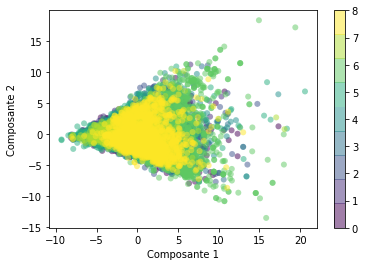

In [96]:
pca = PCA(n_components=10)

pitches_2d_projected = pca.fit_transform(normalized_pitches_stats)

print(pca.explained_variance_ratio_)

plt.scatter(pitches_2d_projected[:, 0], pitches_2d_projected[:, 1],
            c=normalized_df_track_total.labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 9))
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.colorbar();

On voit que les deux premières composantes de l'ACP n'expliquent que 35% de la variance à elles seules, ce qui n'est pas beaucoup. Les 10 premières composantes expliquent 80% de la variance, mais on ne voit pas vraiment une feature se dégager.
Lorsqu'on essaie de projeter les données sur l'espace formé par les deux premières composantes, les genres se superposent : on ne semble pas obtenir une classification évidente à l'aide de ces features.

### ACP sur df_track_total

In [ ]:
pca = PCA(n_components=10)

pitches_2d_projected = pca.fit_transform(normalized_df_track_total.drop(['genre', 'track_artists', 'track_name', 'labels'], axis = 1))

principal_components_features = pca.fit(normalized_df_track_total.drop(['track_artists', 'track_name', 'genre','labels'], axis = 1))
exp_variance = pca.explained_variance_ratio_
print(exp_variance) 

plt.scatter(pitches_2d_projected[:, 0], pitches_2d_projected[:, 1],
            c=normalized_df_track_total.labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 9))
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.colorbar();

C'est encore moins bien qu'avant. On applique donc la réduction de dimension de notre première ACP, sur le dataset normalized_features.



#### On applique la réduction de dimension à la fois au dataset ne contenant que les features de 'bases' et celle contenant les features de bases + les statistiques pitches et timbres

In [99]:
pca = PCA(n_components=10)


principal_components_features = pca.fit(normalized_df_track_total.drop(['track_artists', 'track_name', 'genre','labels'], axis = 1))

print(pca.explained_variance_ratio_)

normalized_df_track_total_reduced = pca.transform(normalized_df_track_total.drop(columns = ['genre','track_artists','track_name', 'labels'], axis=1))
normalized_df_track_total_reduced.shape

#normalized_df_track_total_reduced

[0.1115551  0.07532762 0.05561354 0.04513237 0.03901484 0.02721454
 0.02706479 0.02533293 0.02391909 0.02361595]


(15399, 10)

In [188]:
pca = PCA(n_components=10)

principal_components_features = pca.fit(normalized_df_track.drop(['track_artists', 'track_name', 'genre','labels'], axis = 1))

print(pca.explained_variance_ratio_)

normalized_df_track_reduced = pca.transform(normalized_df_track.drop(columns = ['genre','track_artists','track_name', 'labels'], axis=1))
normalized_df_track_reduced.shape

#normalized_df_track_reduced

[0.25262265 0.12472353 0.0926487  0.08207891 0.07992753 0.06859336
 0.06710432 0.06172689 0.05847569 0.04945049]


(15399, 10)

In [189]:
normalized_df_track_reduced = pd.concat([pd.DataFrame(normalized_df_track_reduced, index = normalized_df_track.index, columns = ['PCA-%d' % k for k in range(1,11)]), normalized_df_track.labels], axis = 1)
normalized_df_track_reduced.head(3)

,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9,PCA-10,labels
id,,,,,,,,,,,
2wiA6eP7rBktnxmjgX8g7U,-0.660233,-0.884289,-1.652105,-0.442349,-0.004894,-0.174960,-0.057763,0.225170,-0.858995,-0.006119,0
48xD8fTt37etYF52AJBiXF,-0.810945,0.833013,0.367621,-0.632585,-0.230626,-0.746594,1.036334,-1.138205,0.418294,0.127021,0
74wIEdRJGZR5aaKu2XnREO,-1.274059,-0.875611,-1.055192,-1.129131,0.068309,-0.010765,0.585917,0.280038,0.009808,0.152422,0


On peut observer sur un graphique les deux premières "nouvelles" coordonnées de chaque morceau pour le dataset ne contenant que les features de base, pour regarder si il est possible de déjà distinguer des catégories.

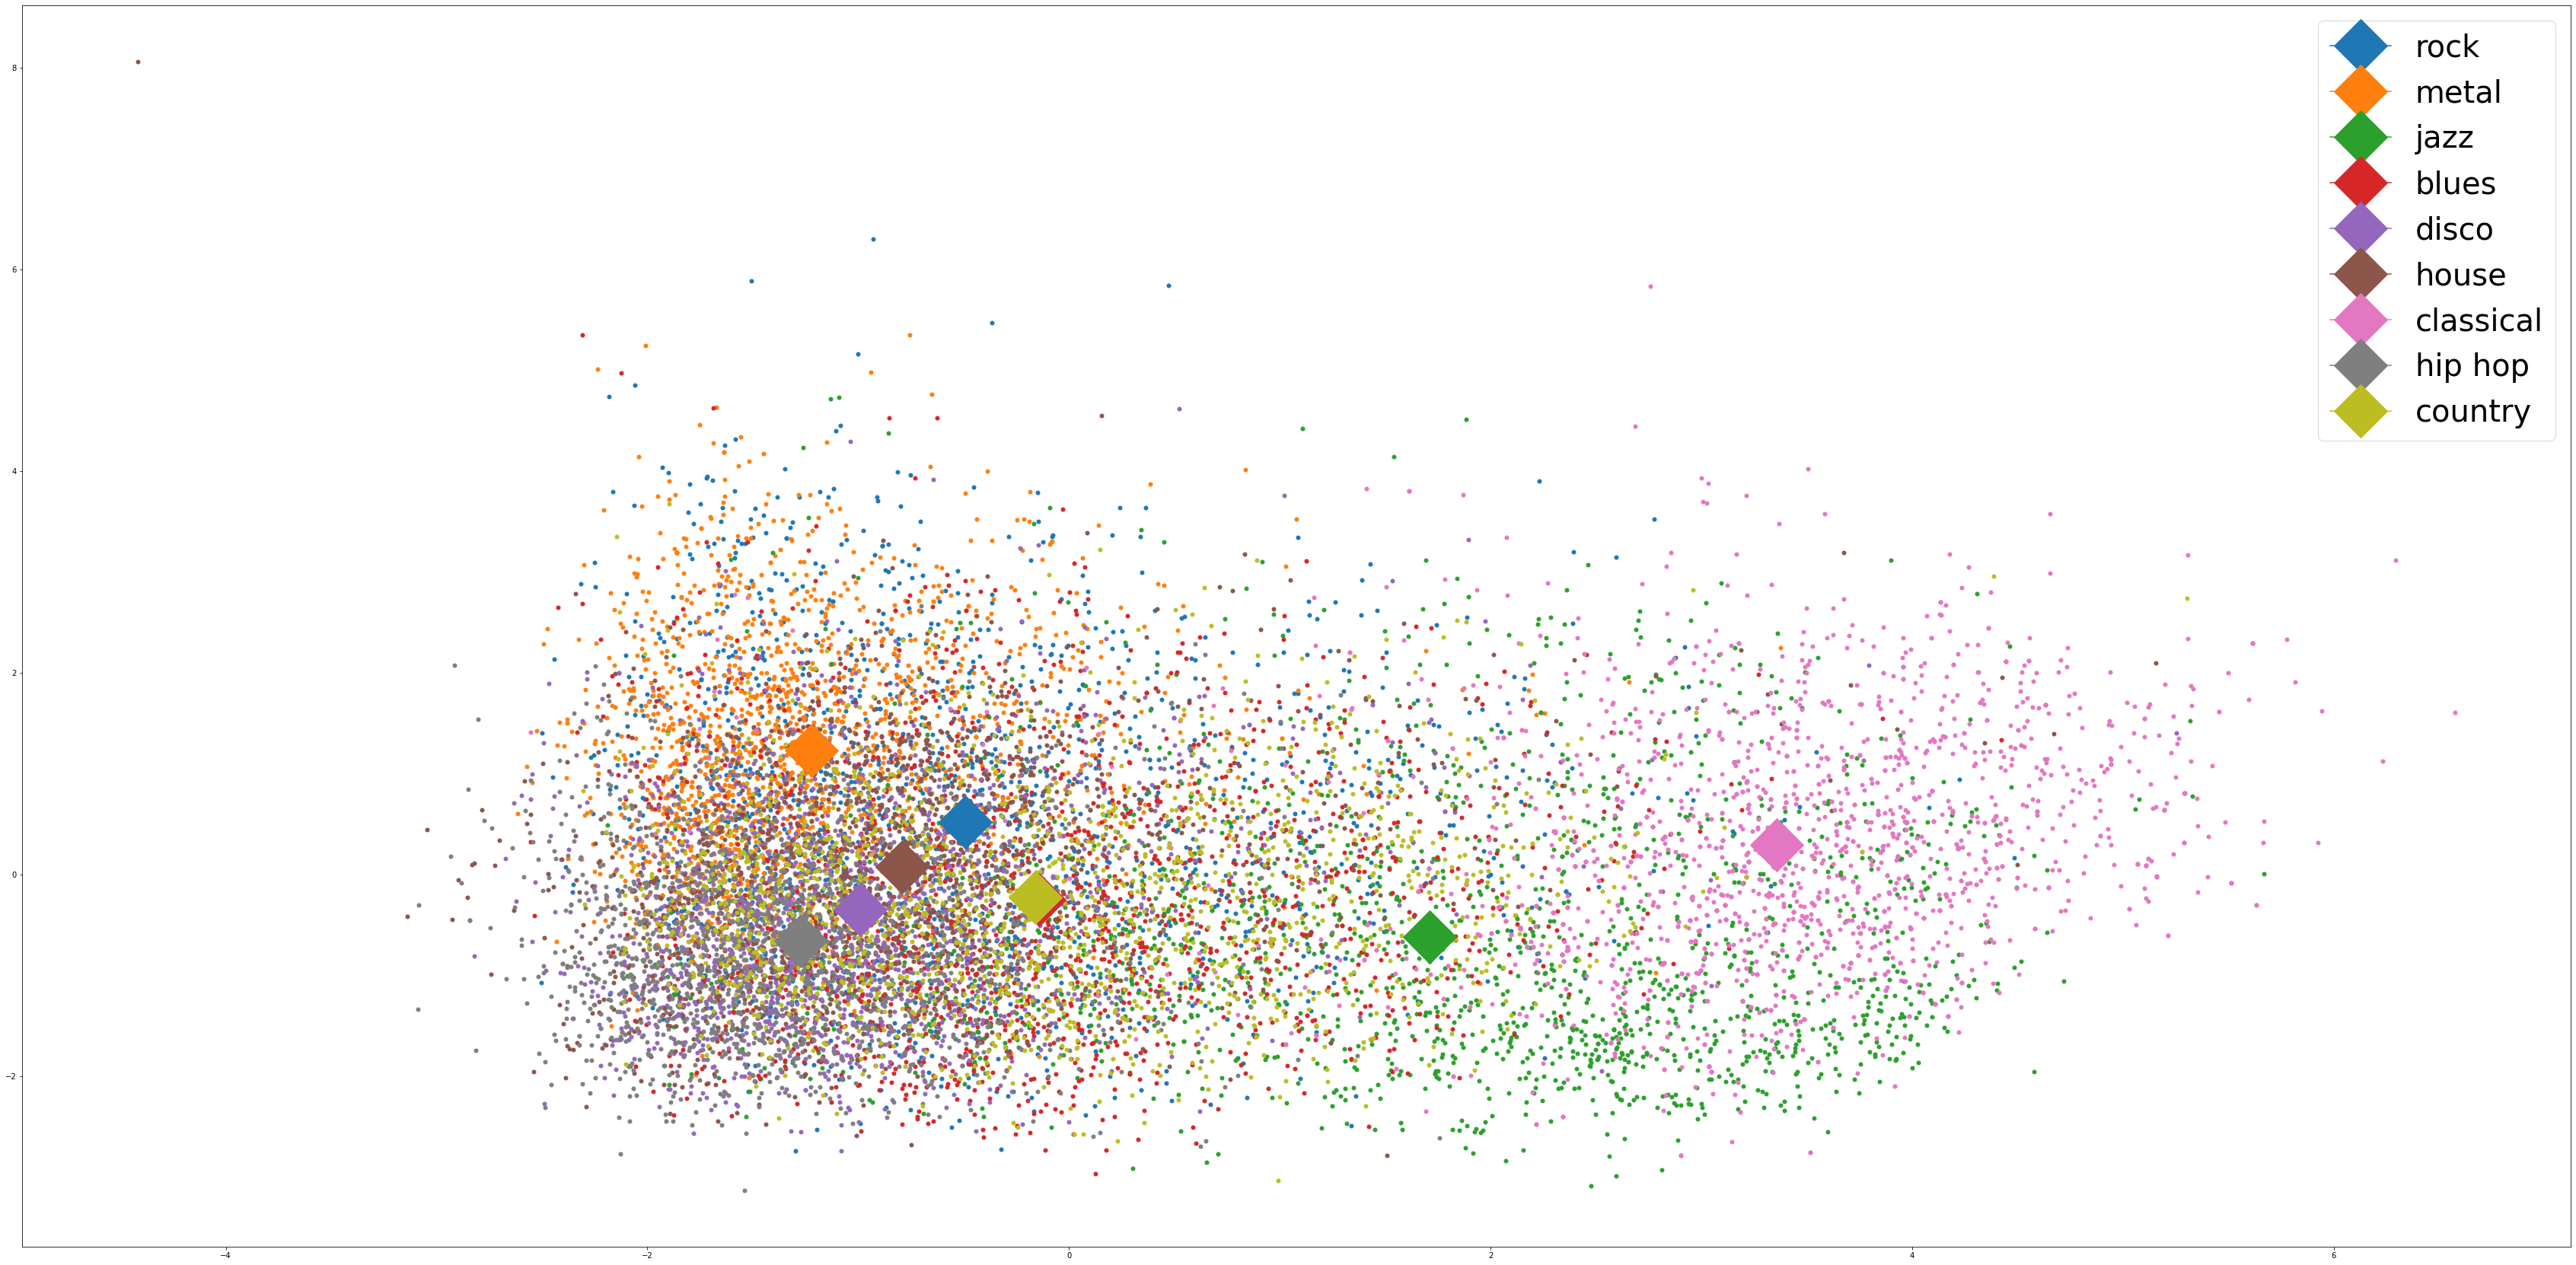

In [219]:
groups = normalized_df_track_reduced.groupby('labels')
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [60,30]
ax.margins(0.05)
cmap = matplotlib.cm.get_cmap('tab10')
for idx, (name, group) in enumerate(groups):
    genre = labels_to_genres[name]
    ax.plot(group['PCA-1'], group['PCA-2'], marker='o', linestyle='', ms=5, zorder=1, c = cmap.colors[idx])
    ax.plot(group['PCA-1'].mean(),group['PCA-2'].mean(), marker='D', ms=50, label= genre, zorder=2, c = cmap.colors[idx])

ax.legend(fontsize = 40)



plt.show()


Ces premiers résultats ne sont pas vraiment exploitables : les genres semblent mélangés dans un seul cluster bien que certains genres semblent se distinguer légèrement : les genre classique et jazz sont par exemple plus à droite, le metal et le hip-hop plus à gauche, on voit aussi que le genre country semble assez peu dispersé. Bien sûr, les deux première dimensions de l'ACP ne peuvent décrire correctement l'ensemble des données. 

On peut malgré tout tenter de déterminer des clusters grâce à la méthode des K-means : méthode d'apprentissage non supervisé.

In [104]:
from sklearn.cluster import AgglomerativeClustering
kmeans = sklearn.cluster.KMeans(n_clusters=9).fit(normalized_df_track_reduced)

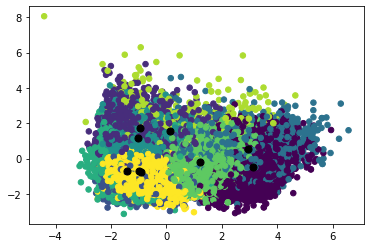

In [109]:
y = kmeans.predict(normalized_df_track_reduced)
centers = kmeans.cluster_centers_
plt.scatter(normalized_df_track_reduced[:,0], normalized_df_track_reduced[:,1], c = y, s = 30, cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=1);


La méthode des K-means semble ici proposer des clusters qui se rapprochent légèrement de la répartition des genres réelle du graphique précédent. L'algorithme semble capable de déterminer des clusters dont les centres semblent se rapprocher des clusters de "genre" réels. Néanmoins on ne peut pas quantifier à quel point ces derniers sont proches de la réalité.

## Modèles de prédiction

### Séparation en train et set 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(normalized_df_track_reduced, labels)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(normalized_df_track_total_reduced, labels)

### KNN

In [ ]:
from sklearn import neighbors

In [ ]:
errors = []
for k in range(2,50):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(2,50), errors, 'o-')
plt.show()

Meilleur K = 28

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=28)
knn.fit(X_train, y_train)
error = 1 - knn.score(X_test, y_test)
print('Erreur: %f' % error)
print('Accuracy: %f' % (1 - error))

In [ ]:
errors = []
for k in range(2,50):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train_total, y_train_total).score(X_test_total, y_test_total)))
plt.plot(range(2,50), errors, 'o-')
plt.show()

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train_total, y_train_total)
error = 1 - knn.score(X_test_total, y_test_total)
print('Erreur: %f' % error)
print('Accuracy: %f' % (1 - error))

Meilleur K = 50. Mais toujours une erreur importante qui semblent stagner autour de 50.

Même si l'erreur reste moins forte que si on attribuait les genres au hasard, l'algorithme KNN reste assez peu performant pour prédire le genre d'un morceau.

### Classification Linéaire

On utilise un module de classification proposé par sklearn : la Décente de Gradient Stochastique. Il s'agit d'un modèle linéaire simple qui ne devrait pas offrir d'excellents résultats, mais il ne risque pas d'overfitter.
L’overfitting correspond en effet a un phénomène de surapprentissage de l'algorithme qui apprend "trop précisemment" sur les données de la base de train et manque de capacité de généralisation. 

In [8]:
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

In [35]:
from sklearn.linear_model import SGDClassifier
sgd_normalized_df_track_total = SGDClassifier(loss = 'log').fit(X_train_total, y_train_total)  

NameError: name 'X_train_total' is not defined

In [10]:
print('MSE:', '\ntrain:', mean_squared_error(y_train_total, sgd_normalized_df_track_total.predict(X_train_total)),
              '\ntest:', mean_squared_error(y_test_total, sgd_normalized_df_track_total.predict(X_test_total))
     ) 

NameError: name 'y_train_total' is not defined

In [11]:
confusion_matrix(y_test_total, sgd_normalized_df_track_total.predict(X_test_total))

NameError: name 'y_test_total' is not defined

In [12]:
accuracy_score(y_test_total, sgd_normalized_df_track_total.predict(X_test_total))

NameError: name 'y_test_total' is not defined

In [13]:
sgd_normalized_df_track = SGDClassifier(loss = 'log').fit(X_train, y_train)  
print('MSE:', '\ntrain:', mean_squared_error(y_train, sgd_normalized_df_track.predict(X_train)),
              '\ntest:', mean_squared_error(y_test, sgd_normalized_df_track.predict(X_test))
     ) 

NameError: name 'X_train' is not defined

In [14]:
confusion_matrix(y_test, sgd_normalized_df_track.predict(X_test))

NameError: name 'y_test' is not defined

In [15]:
accuracy_score(y_test, sgd_normalized_df_track.predict(X_test))

NameError: name 'y_test' is not defined

Dans le cas du SGD Classifier, la base enrichie (features + stat pitches et timbres), plus complète, offre un taux d'accuracy significativement meilleur. Les features utilisées pour décrire les pitches et les timbres sont donc utiles pour la prédiction avec cet algorithme, ce qui n'était pas le cas pour KNN. Ce classifier offre cependant une erreur légèrement plus importante (55% environ) que l'algorithme KNN.

Pour voir si overfit : f1 score + accuracy score sur base de train. pas calculer la mean squared error (a enlever)

### Arbre de décision

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
from sklearn.tree import DecisionTreeClassifier
tree_track_total = DecisionTreeClassifier().fit(X_train_total, y_train_total)

tree_track = DecisionTreeClassifier().fit(X_train, y_train)

NameError: name 'X_train_total' is not defined

In [18]:
parameters = {'max_depth':[4,5,6,7,8,9,10,15], 'min_samples_leaf':range(5,15),
              'min_samples_split':range(2,10)}
tree_track_total = DecisionTreeClassifier() 
tree_search_track_total = GridSearchCV(tree_track_total, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
tree_search_track_total.fit(X_train_total, y_train_total)
tree_track_total = tree_search_track_total.best_estimator_    # On récupère le "meilleur" modèle

NameError: name 'X_train_total' is not defined

In [19]:
parameters = {'max_depth':[4,5,6,7,8,9,10,15], 'min_samples_leaf':range(5,15),
              'min_samples_split':range(2,10)}
tree_track = DecisionTreeClassifier() 
tree_search_track = GridSearchCV(tree_track, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
tree_search_track.fit(X_train, y_train)
tree_track = tree_search_track.best_estimator_ 

NameError: name 'X_train' is not defined

In [20]:
tree_search_track_total.best_params_ 

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [21]:
tree_search_track.best_params_ 

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [22]:
print(accuracy_score(y_test_total, tree_track_total.predict(X_test_total)))
print(accuracy_score(y_test, tree_track.predict(X_test)))

NameError: name 'y_test_total' is not defined

#### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rfc_track_total = RandomForestClassifier()
rfc_track_total.fit(X_train_total, y_train_total)


NameError: name 'X_train_total' is not defined

In [24]:
rfc_track = RandomForestClassifier()
rfc_track.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [25]:
parameters = {'max_depth':[2,3,4,5,7,8], 'min_samples_leaf':[2,3,4,5,6],
              'max_features':["auto"], 'n_estimators':[20,30,40,50]}
rfc_track_total = RandomForestClassifier()
rf_search_track_total = GridSearchCV(rfc_track_total, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
rf_search_track_total.fit(X_train_total, y_train_total)
rfc_track_total = rf_search_track_total.best_estimator_

NameError: name 'X_train_total' is not defined

In [26]:
parameters = {'max_depth':[2,3,4,5,7,8], 'min_samples_leaf':[2,3,4,5,6],
              'max_features':["auto"], 'n_estimators':[20,30,40,50]}
rfc_track = RandomForestClassifier()
rf_search_track = GridSearchCV(rfc_track, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
rf_search_track.fit(X_train
                    , y_train)
rfc_track = rf_search_track.best_estimator_

NameError: name 'X_train' is not defined

In [27]:
rf_search_track.best_params_

rf_search_track_total.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [28]:
accuracy_score(y_test_total, rfc_track.predict(X_test_total))

NameError: name 'y_test_total' is not defined

In [29]:
accuracy_score(y_test, rfc_track.predict(X_test))

NameError: name 'y_test' is not defined

In [30]:

import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms


In [ ]:
parameters = {'max_depth':[2,3,4,5,7,8], 'eta':[0.1,0.2,0.3],
              'max_features':["auto"], 'n_estimators':[50,100,150]}
xgb_track = XGBClassifier(objective='multi:softprob', num_classes=9)
xgb_search_track = GridSearchCV(xgb_track, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
xgb_search_track.fit(X_train, y_train)
xgb_search_track = xgb_search_track.best_estimator_

In [4]:

import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import precision_score

iris = datasets.load_iris()
X = iris.data
y = iris.target



In [6]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])